In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from keras import regularizers, optimizers, layers, models
from IPython.display import display
import os
%matplotlib inline
matplotlib.style.use('ggplot')

Using TensorFlow backend.


In [2]:
# DATA PARAMETERS
DATASET_NAME = os.path.join("..", "data", "creditcard.csv")
NUMBER_OF_OK_TRANSACTIONS_IN_TRAIN_VALIDATION_DATASET = 400
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 1000
BATCH_SIZE = 50
LEARNING_RATE = 0.001
NUMBER_OF_NEURONS = 1024
REGULARIZATION_LAMBDA = 0.1

In [3]:
# Read CSV
dataset = pd.read_csv(DATASET_NAME)
dataset = dataset.drop(['Time','Amount'],axis=1)

NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'

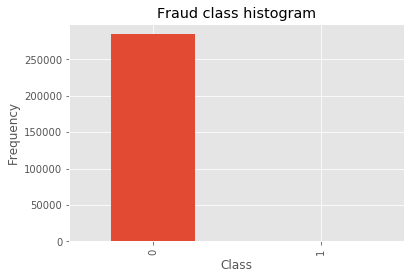

0    284315
1       492
Name: Class, dtype: int64

In [4]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [5]:
# Split dataset on train_and_validation dataset and test dataset
train_and_validation, test = train_test_split(dataset, test_size = 0.2, random_state = 0)

# Convert test data to numpyarray and split them.
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]

In [6]:
# Create balanced, under sample train and validation dataset 
fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)

random_normal_indices = np.random.choice(normal_indices, NUMBER_OF_OK_TRANSACTIONS_IN_TRAIN_VALIDATION_DATASET, replace = False)
random_normal_indices = np.array(random_normal_indices)

under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

under_sample_dataset = dataset.iloc[under_sample_indices,:]

# Shuffle train and validation dataset
under_sample_dataset = under_sample_dataset.sample(frac=1)

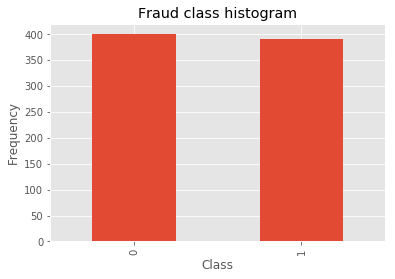

0    400
1    391
Name: Class, dtype: int64

In [7]:
# Plot histogram for training and validation dataset
count_classes = pd.value_counts(under_sample_dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [8]:
# Convert training and validation dataset to numpy array
under_sample_dataset = under_sample_dataset.values

In [9]:
# Pot loss
def show_loss(history):   
    x_axis = range(0, EPOCHS)
    fig, ax = plt.subplots()
    ax.plot(x_axis, history.history['loss'], label='train_loss')
    ax.plot(x_axis, history.history['val_loss'], label='val_loss')
    ax.legend()
    plt.ylabel('Log loss')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    
    plt.show()

In [10]:
def plot_ROC(TPR_array, FPR_array):   
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [11]:
# NN model
import keras.backend as K

def precision(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TP_plus_FP = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return TP / (TP_plus_FP + K.epsilon())

def recall(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TP_plus_FN = K.sum(K.round(K.clip(y_true, 0, 1)))
    return TP / (TP_plus_FN + K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * prec * rec / (prec + rec + K.epsilon())

def nn_model():
    model = models.Sequential()
    model.add(layers.Dense(NUMBER_OF_NEURONS,
                    input_dim=NUMBER_OF_FEATURES,
                    activation='relu',
                    kernel_regularizer=regularizers.l2(REGULARIZATION_LAMBDA)))
#     model.add(layers.Dense(NUMBER_OF_NEURONS, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    optimazier = optimizers.SGD(lr=LEARNING_RATE)
    model.compile(optimizer=optimazier,
                  loss='binary_crossentropy',
                  metrics=['accuracy', precision, recall, f1_score])
    return model

train_results = {'models': [], 'history': [], 'score': []}

kf = KFold(n_splits=N_SPLITS)
for train_index, validation_index in kf.split(under_sample_dataset):
    k_fold_train, k_fold_validation = under_sample_dataset[train_index], under_sample_dataset[validation_index]

    x_train = k_fold_train[:,:-1]
    y_train = k_fold_train[:,-1:]
        
    x_validation = k_fold_validation[:,:-1]
    y_validation = k_fold_validation[:,-1:]
    
    model = nn_model()
    history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), verbose=1, epochs=EPOCHS, batch_size=BATCH_SIZE)
    score = model.evaluate(x_validation, y_validation, batch_size=BATCH_SIZE)
    
    train_results['models'].append(model)
    train_results['history'].append(history)
    train_results['score'].append(score)

Train on 632 samples, validate on 159 samples
Epoch 1/1000
632/632 [==============================] - 0s - loss: 5.9079 - acc: 0.5854 - precision: 0.5436 - recall: 0.9793 - f1_score: 0.6955 - val_loss: 5.8821 - val_acc: 0.5409 - val_precision: 0.5229 - val_recall: 0.9617 - val_f1_score: 0.6764
Epoch 2/1000
632/632 [==============================] - 0s - loss: 5.8709 - acc: 0.6076 - precision: 0.5590 - recall: 0.9805 - f1_score: 0.7086 - val_loss: 5.8460 - val_acc: 0.5660 - val_precision: 0.5365 - val_recall: 0.9617 - val_f1_score: 0.6879
Epoch 3/1000
632/632 [==============================] - 0s - loss: 5.8352 - acc: 0.6234 - precision: 0.5644 - recall: 0.9795 - f1_score: 0.7097 - val_loss: 5.8111 - val_acc: 0.5849 - val_precision: 0.5481 - val_recall: 0.9617 - val_f1_score: 0.6976
Epoch 4/1000
632/632 [==============================] - 0s - loss: 5.8004 - acc: 0.6487 - precision: 0.5842 - recall: 0.9842 - f1_score: 0.7305 - val_loss: 5.7771 - val_acc: 0.5975 - val_precision: 0.5564 - 

632/632 [==============================] - 0s - loss: 4.9489 - acc: 0.9525 - precision: 0.9741 - recall: 0.9301 - f1_score: 0.9508 - val_loss: 4.9369 - val_acc: 0.9119 - val_precision: 0.9480 - val_recall: 0.8783 - val_f1_score: 0.9103
Epoch 34/1000
632/632 [==============================] - 0s - loss: 4.9230 - acc: 0.9525 - precision: 0.9729 - recall: 0.9274 - f1_score: 0.9489 - val_loss: 4.9113 - val_acc: 0.9182 - val_precision: 0.9595 - val_recall: 0.8783 - val_f1_score: 0.9157
Epoch 35/1000
632/632 [==============================] - 0s - loss: 4.8973 - acc: 0.9525 - precision: 0.9742 - recall: 0.9280 - f1_score: 0.9501 - val_loss: 4.8858 - val_acc: 0.9182 - val_precision: 0.9595 - val_recall: 0.8783 - val_f1_score: 0.9157
Epoch 36/1000
632/632 [==============================] - 0s - loss: 4.8717 - acc: 0.9541 - precision: 0.9767 - recall: 0.9318 - f1_score: 0.9529 - val_loss: 4.8606 - val_acc: 0.9182 - val_precision: 0.9595 - val_recall: 0.8783 - val_f1_score: 0.9157
Epoch 37/1000


632/632 [==============================] - 0s - loss: 4.1982 - acc: 0.9399 - precision: 0.9819 - recall: 0.8923 - f1_score: 0.9333 - val_loss: 4.1944 - val_acc: 0.9245 - val_precision: 0.9863 - val_recall: 0.8640 - val_f1_score: 0.9207
Epoch 66/1000
632/632 [==============================] - 0s - loss: 4.1771 - acc: 0.9415 - precision: 0.9829 - recall: 0.8952 - f1_score: 0.9356 - val_loss: 4.1735 - val_acc: 0.9245 - val_precision: 0.9863 - val_recall: 0.8640 - val_f1_score: 0.9207
Epoch 67/1000
632/632 [==============================] - 0s - loss: 4.1560 - acc: 0.9399 - precision: 0.9816 - recall: 0.8910 - f1_score: 0.9326 - val_loss: 4.1527 - val_acc: 0.9245 - val_precision: 0.9863 - val_recall: 0.8640 - val_f1_score: 0.9207
Epoch 68/1000
632/632 [==============================] - 0s - loss: 4.1351 - acc: 0.9415 - precision: 0.9820 - recall: 0.8952 - f1_score: 0.9355 - val_loss: 4.1320 - val_acc: 0.9245 - val_precision: 0.9863 - val_recall: 0.8640 - val_f1_score: 0.9207
Epoch 69/1000


632/632 [==============================] - 0s - loss: 3.5789 - acc: 0.9399 - precision: 0.9833 - recall: 0.8966 - f1_score: 0.9369 - val_loss: 3.5810 - val_acc: 0.9245 - val_precision: 0.9863 - val_recall: 0.8640 - val_f1_score: 0.9207
Epoch 98/1000
632/632 [==============================] - 0s - loss: 3.5613 - acc: 0.9399 - precision: 0.9823 - recall: 0.8943 - f1_score: 0.9349 - val_loss: 3.5635 - val_acc: 0.9245 - val_precision: 0.9863 - val_recall: 0.8640 - val_f1_score: 0.9207
Epoch 99/1000
632/632 [==============================] - 0s - loss: 3.5438 - acc: 0.9399 - precision: 0.9830 - recall: 0.8923 - f1_score: 0.9347 - val_loss: 3.5462 - val_acc: 0.9245 - val_precision: 0.9863 - val_recall: 0.8640 - val_f1_score: 0.9207
Epoch 100/1000
632/632 [==============================] - 0s - loss: 3.5264 - acc: 0.9399 - precision: 0.9839 - recall: 0.8912 - f1_score: 0.9333 - val_loss: 3.5289 - val_acc: 0.9245 - val_precision: 0.9863 - val_recall: 0.8640 - val_f1_score: 0.9207
Epoch 101/100

632/632 [==============================] - 0s - loss: 3.0608 - acc: 0.9415 - precision: 0.9862 - recall: 0.8930 - f1_score: 0.9359 - val_loss: 3.0672 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 130/1000
632/632 [==============================] - 0s - loss: 3.0461 - acc: 0.9415 - precision: 0.9888 - recall: 0.8924 - f1_score: 0.9367 - val_loss: 3.0526 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 131/1000
632/632 [==============================] - 0s - loss: 3.0314 - acc: 0.9415 - precision: 0.9841 - recall: 0.8972 - f1_score: 0.9371 - val_loss: 3.0380 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 132/1000
632/632 [==============================] - 0s - loss: 3.0167 - acc: 0.9415 - precision: 0.9863 - recall: 0.8944 - f1_score: 0.9372 - val_loss: 3.0235 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 133/1

632/632 [==============================] - 0s - loss: 2.6250 - acc: 0.9415 - precision: 0.9858 - recall: 0.8911 - f1_score: 0.9350 - val_loss: 2.6346 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 162/1000
632/632 [==============================] - 0s - loss: 2.6125 - acc: 0.9415 - precision: 0.9860 - recall: 0.8962 - f1_score: 0.9376 - val_loss: 2.6222 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 163/1000
632/632 [==============================] - 0s - loss: 2.6001 - acc: 0.9415 - precision: 0.9865 - recall: 0.8944 - f1_score: 0.9376 - val_loss: 2.6099 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 164/1000
632/632 [==============================] - 0s - loss: 2.5878 - acc: 0.9415 - precision: 0.9844 - recall: 0.8926 - f1_score: 0.9348 - val_loss: 2.5977 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 165/1

632/632 [==============================] - 0s - loss: 2.2572 - acc: 0.9383 - precision: 0.9865 - recall: 0.8885 - f1_score: 0.9342 - val_loss: 2.2693 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 194/1000
632/632 [==============================] - 0s - loss: 2.2466 - acc: 0.9383 - precision: 0.9861 - recall: 0.8919 - f1_score: 0.9341 - val_loss: 2.2588 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 195/1000
632/632 [==============================] - 0s - loss: 2.2362 - acc: 0.9383 - precision: 0.9878 - recall: 0.8881 - f1_score: 0.9330 - val_loss: 2.2484 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 196/1000
632/632 [==============================] - 0s - loss: 2.2258 - acc: 0.9383 - precision: 0.9865 - recall: 0.8854 - f1_score: 0.9304 - val_loss: 2.2381 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 197/1

632/632 [==============================] - 0s - loss: 1.9463 - acc: 0.9383 - precision: 0.9860 - recall: 0.8879 - f1_score: 0.9327 - val_loss: 1.9604 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 226/1000
632/632 [==============================] - 0s - loss: 1.9374 - acc: 0.9383 - precision: 0.9849 - recall: 0.8882 - f1_score: 0.9331 - val_loss: 1.9515 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 227/1000
632/632 [==============================] - 0s - loss: 1.9285 - acc: 0.9383 - precision: 0.9856 - recall: 0.8873 - f1_score: 0.9319 - val_loss: 1.9427 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 228/1000
632/632 [==============================] - 0s - loss: 1.9197 - acc: 0.9383 - precision: 0.9856 - recall: 0.8912 - f1_score: 0.9340 - val_loss: 1.9339 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 229/1

632/632 [==============================] - 0s - loss: 1.6832 - acc: 0.9399 - precision: 0.9897 - recall: 0.8864 - f1_score: 0.9343 - val_loss: 1.6988 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 258/1000
632/632 [==============================] - 0s - loss: 1.6757 - acc: 0.9399 - precision: 0.9894 - recall: 0.8859 - f1_score: 0.9342 - val_loss: 1.6913 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 259/1000
632/632 [==============================] - 0s - loss: 1.6682 - acc: 0.9399 - precision: 0.9891 - recall: 0.8875 - f1_score: 0.9349 - val_loss: 1.6839 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 260/1000
632/632 [==============================] - 0s - loss: 1.6607 - acc: 0.9399 - precision: 0.9901 - recall: 0.8896 - f1_score: 0.9353 - val_loss: 1.6764 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 261/1

632/632 [==============================] - 0s - loss: 1.4604 - acc: 0.9415 - precision: 0.9909 - recall: 0.8937 - f1_score: 0.9384 - val_loss: 1.4772 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 290/1000
632/632 [==============================] - 0s - loss: 1.4540 - acc: 0.9415 - precision: 0.9905 - recall: 0.8908 - f1_score: 0.9374 - val_loss: 1.4708 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 291/1000
632/632 [==============================] - 0s - loss: 1.4477 - acc: 0.9415 - precision: 0.9890 - recall: 0.8901 - f1_score: 0.9358 - val_loss: 1.4645 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 292/1000
632/632 [==============================] - 0s - loss: 1.4413 - acc: 0.9415 - precision: 0.9895 - recall: 0.8921 - f1_score: 0.9374 - val_loss: 1.4582 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 293/1

632/632 [==============================] - 0s - loss: 1.2716 - acc: 0.9430 - precision: 0.9900 - recall: 0.8908 - f1_score: 0.9361 - val_loss: 1.2894 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 322/1000
632/632 [==============================] - 0s - loss: 1.2662 - acc: 0.9430 - precision: 0.9900 - recall: 0.8932 - f1_score: 0.9383 - val_loss: 1.2840 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 323/1000
632/632 [==============================] - 0s - loss: 1.2608 - acc: 0.9430 - precision: 0.9896 - recall: 0.9012 - f1_score: 0.9421 - val_loss: 1.2787 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 324/1000
632/632 [==============================] - 0s - loss: 1.2554 - acc: 0.9430 - precision: 0.9902 - recall: 0.8964 - f1_score: 0.9398 - val_loss: 1.2733 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 325/1

632/632 [==============================] - 0s - loss: 1.1114 - acc: 0.9430 - precision: 0.9894 - recall: 0.8909 - f1_score: 0.9363 - val_loss: 1.1301 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 354/1000
632/632 [==============================] - 0s - loss: 1.1068 - acc: 0.9430 - precision: 0.9897 - recall: 0.8942 - f1_score: 0.9386 - val_loss: 1.1255 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 355/1000
632/632 [==============================] - 0s - loss: 1.1022 - acc: 0.9430 - precision: 0.9899 - recall: 0.8950 - f1_score: 0.9388 - val_loss: 1.1210 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 356/1000
632/632 [==============================] - 0s - loss: 1.0977 - acc: 0.9430 - precision: 0.9885 - recall: 0.8967 - f1_score: 0.9394 - val_loss: 1.1165 - val_acc: 0.9371 - val_precision: 1.0000 - val_recall: 0.8752 - val_f1_score: 0.9329
Epoch 357/1

632/632 [==============================] - 0s - loss: 0.9754 - acc: 0.9446 - precision: 0.9892 - recall: 0.8986 - f1_score: 0.9410 - val_loss: 0.9949 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 386/1000
632/632 [==============================] - 0s - loss: 0.9715 - acc: 0.9446 - precision: 0.9900 - recall: 0.8967 - f1_score: 0.9397 - val_loss: 0.9910 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 387/1000
632/632 [==============================] - 0s - loss: 0.9676 - acc: 0.9446 - precision: 0.9892 - recall: 0.8927 - f1_score: 0.9369 - val_loss: 0.9871 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 388/1000
632/632 [==============================] - 0s - loss: 0.9637 - acc: 0.9446 - precision: 0.9891 - recall: 0.8962 - f1_score: 0.9393 - val_loss: 0.9833 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 389/1

632/632 [==============================] - 0s - loss: 0.8598 - acc: 0.9446 - precision: 0.9898 - recall: 0.8990 - f1_score: 0.9414 - val_loss: 0.8800 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 418/1000
632/632 [==============================] - 0s - loss: 0.8565 - acc: 0.9462 - precision: 0.9890 - recall: 0.9014 - f1_score: 0.9424 - val_loss: 0.8767 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 419/1000
632/632 [==============================] - 0s - loss: 0.8532 - acc: 0.9462 - precision: 0.9898 - recall: 0.8999 - f1_score: 0.9419 - val_loss: 0.8734 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 420/1000
632/632 [==============================] - 0s - loss: 0.8499 - acc: 0.9462 - precision: 0.9887 - recall: 0.8996 - f1_score: 0.9410 - val_loss: 0.8701 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 421/1

632/632 [==============================] - 0s - loss: 0.7616 - acc: 0.9462 - precision: 0.9883 - recall: 0.8986 - f1_score: 0.9406 - val_loss: 0.7823 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 450/1000
632/632 [==============================] - 0s - loss: 0.7588 - acc: 0.9462 - precision: 0.9887 - recall: 0.9027 - f1_score: 0.9431 - val_loss: 0.7795 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 451/1000
632/632 [==============================] - 0s - loss: 0.7560 - acc: 0.9462 - precision: 0.9886 - recall: 0.9004 - f1_score: 0.9407 - val_loss: 0.7767 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 452/1000
632/632 [==============================] - 0s - loss: 0.7532 - acc: 0.9462 - precision: 0.9896 - recall: 0.9003 - f1_score: 0.9422 - val_loss: 0.7739 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 453/1

632/632 [==============================] - 0s - loss: 0.6780 - acc: 0.9462 - precision: 0.9898 - recall: 0.8992 - f1_score: 0.9409 - val_loss: 0.6992 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 482/1000
632/632 [==============================] - 0s - loss: 0.6756 - acc: 0.9462 - precision: 0.9908 - recall: 0.8974 - f1_score: 0.9406 - val_loss: 0.6968 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 483/1000
632/632 [==============================] - 0s - loss: 0.6732 - acc: 0.9462 - precision: 0.9894 - recall: 0.8991 - f1_score: 0.9409 - val_loss: 0.6945 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 484/1000
632/632 [==============================] - 0s - loss: 0.6708 - acc: 0.9462 - precision: 0.9903 - recall: 0.8996 - f1_score: 0.9415 - val_loss: 0.6921 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 485/1

632/632 [==============================] - 0s - loss: 0.6068 - acc: 0.9462 - precision: 0.9902 - recall: 0.9011 - f1_score: 0.9422 - val_loss: 0.6285 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 514/1000
632/632 [==============================] - 0s - loss: 0.6047 - acc: 0.9462 - precision: 0.9888 - recall: 0.9023 - f1_score: 0.9426 - val_loss: 0.6265 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 515/1000
632/632 [==============================] - 0s - loss: 0.6027 - acc: 0.9462 - precision: 0.9898 - recall: 0.9009 - f1_score: 0.9424 - val_loss: 0.6244 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 516/1000
632/632 [==============================] - 0s - loss: 0.6007 - acc: 0.9462 - precision: 0.9871 - recall: 0.8962 - f1_score: 0.9384 - val_loss: 0.6224 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 517/1

632/632 [==============================] - 0s - loss: 0.5461 - acc: 0.9462 - precision: 0.9897 - recall: 0.8993 - f1_score: 0.9415 - val_loss: 0.5682 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 546/1000
632/632 [==============================] - 0s - loss: 0.5443 - acc: 0.9462 - precision: 0.9907 - recall: 0.8999 - f1_score: 0.9416 - val_loss: 0.5665 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 547/1000
632/632 [==============================] - 0s - loss: 0.5426 - acc: 0.9462 - precision: 0.9880 - recall: 0.8992 - f1_score: 0.9406 - val_loss: 0.5647 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 548/1000
632/632 [==============================] - 0s - loss: 0.5409 - acc: 0.9462 - precision: 0.9899 - recall: 0.9008 - f1_score: 0.9428 - val_loss: 0.5630 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 549/1

632/632 [==============================] - 0s - loss: 0.4942 - acc: 0.9462 - precision: 0.9895 - recall: 0.8975 - f1_score: 0.9394 - val_loss: 0.5168 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 578/1000
632/632 [==============================] - 0s - loss: 0.4927 - acc: 0.9462 - precision: 0.9894 - recall: 0.8968 - f1_score: 0.9396 - val_loss: 0.5153 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 579/1000
632/632 [==============================] - 0s - loss: 0.4912 - acc: 0.9462 - precision: 0.9890 - recall: 0.8980 - f1_score: 0.9402 - val_loss: 0.5139 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 580/1000
632/632 [==============================] - 0s - loss: 0.4898 - acc: 0.9462 - precision: 0.9926 - recall: 0.8960 - f1_score: 0.9407 - val_loss: 0.5124 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 581/1

632/632 [==============================] - 0s - loss: 0.4499 - acc: 0.9462 - precision: 0.9883 - recall: 0.9008 - f1_score: 0.9419 - val_loss: 0.4730 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 610/1000
632/632 [==============================] - 0s - loss: 0.4486 - acc: 0.9462 - precision: 0.9886 - recall: 0.9034 - f1_score: 0.9415 - val_loss: 0.4717 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 611/1000
632/632 [==============================] - 0s - loss: 0.4473 - acc: 0.9462 - precision: 0.9901 - recall: 0.9039 - f1_score: 0.9446 - val_loss: 0.4704 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 612/1000
632/632 [==============================] - 0s - loss: 0.4461 - acc: 0.9462 - precision: 0.9902 - recall: 0.9003 - f1_score: 0.9425 - val_loss: 0.4692 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 613/1

632/632 [==============================] - 0s - loss: 0.4119 - acc: 0.9446 - precision: 0.9860 - recall: 0.9017 - f1_score: 0.9407 - val_loss: 0.4354 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 642/1000
632/632 [==============================] - 0s - loss: 0.4108 - acc: 0.9462 - precision: 0.9888 - recall: 0.9022 - f1_score: 0.9423 - val_loss: 0.4343 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 643/1000
632/632 [==============================] - 0s - loss: 0.4097 - acc: 0.9446 - precision: 0.9861 - recall: 0.9022 - f1_score: 0.9411 - val_loss: 0.4333 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 644/1000
632/632 [==============================] - 0s - loss: 0.4087 - acc: 0.9446 - precision: 0.9840 - recall: 0.9022 - f1_score: 0.9397 - val_loss: 0.4322 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 645/1

632/632 [==============================] - 0s - loss: 0.3794 - acc: 0.9446 - precision: 0.9873 - recall: 0.9022 - f1_score: 0.9421 - val_loss: 0.4033 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 674/1000
632/632 [==============================] - 0s - loss: 0.3784 - acc: 0.9446 - precision: 0.9862 - recall: 0.9007 - f1_score: 0.9406 - val_loss: 0.4023 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 675/1000
632/632 [==============================] - 0s - loss: 0.3775 - acc: 0.9446 - precision: 0.9871 - recall: 0.9028 - f1_score: 0.9413 - val_loss: 0.4014 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 676/1000
632/632 [==============================] - 0s - loss: 0.3766 - acc: 0.9446 - precision: 0.9854 - recall: 0.9008 - f1_score: 0.9400 - val_loss: 0.4005 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 677/1

632/632 [==============================] - 0s - loss: 0.3514 - acc: 0.9446 - precision: 0.9866 - recall: 0.9007 - f1_score: 0.9404 - val_loss: 0.3757 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 706/1000
632/632 [==============================] - 0s - loss: 0.3506 - acc: 0.9446 - precision: 0.9829 - recall: 0.9020 - f1_score: 0.9387 - val_loss: 0.3749 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 707/1000
632/632 [==============================] - 0s - loss: 0.3498 - acc: 0.9446 - precision: 0.9858 - recall: 0.9005 - f1_score: 0.9403 - val_loss: 0.3741 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 708/1000
632/632 [==============================] - 0s - loss: 0.3490 - acc: 0.9446 - precision: 0.9864 - recall: 0.9057 - f1_score: 0.9429 - val_loss: 0.3733 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 709/1

632/632 [==============================] - 0s - loss: 0.3273 - acc: 0.9446 - precision: 0.9860 - recall: 0.9034 - f1_score: 0.9414 - val_loss: 0.3520 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 738/1000
632/632 [==============================] - 0s - loss: 0.3266 - acc: 0.9446 - precision: 0.9860 - recall: 0.9039 - f1_score: 0.9419 - val_loss: 0.3514 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 739/1000
632/632 [==============================] - 0s - loss: 0.3259 - acc: 0.9446 - precision: 0.9862 - recall: 0.9027 - f1_score: 0.9416 - val_loss: 0.3507 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 740/1000
632/632 [==============================] - 0s - loss: 0.3252 - acc: 0.9446 - precision: 0.9864 - recall: 0.8996 - f1_score: 0.9399 - val_loss: 0.3500 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 741/1

632/632 [==============================] - 0s - loss: 0.3066 - acc: 0.9446 - precision: 0.9843 - recall: 0.8990 - f1_score: 0.9389 - val_loss: 0.3317 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 770/1000
632/632 [==============================] - 0s - loss: 0.3060 - acc: 0.9446 - precision: 0.9869 - recall: 0.9017 - f1_score: 0.9410 - val_loss: 0.3311 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 771/1000
632/632 [==============================] - 0s - loss: 0.3054 - acc: 0.9446 - precision: 0.9853 - recall: 0.9009 - f1_score: 0.9401 - val_loss: 0.3305 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 772/1000
632/632 [==============================] - 0s - loss: 0.3048 - acc: 0.9446 - precision: 0.9849 - recall: 0.9035 - f1_score: 0.9404 - val_loss: 0.3299 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 773/1

632/632 [==============================] - 0s - loss: 0.2887 - acc: 0.9446 - precision: 0.9859 - recall: 0.9018 - f1_score: 0.9411 - val_loss: 0.3142 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 802/1000
632/632 [==============================] - 0s - loss: 0.2881 - acc: 0.9446 - precision: 0.9875 - recall: 0.9006 - f1_score: 0.9414 - val_loss: 0.3137 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 803/1000
632/632 [==============================] - 0s - loss: 0.2876 - acc: 0.9446 - precision: 0.9857 - recall: 0.9017 - f1_score: 0.9401 - val_loss: 0.3132 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 804/1000
632/632 [==============================] - 0s - loss: 0.2871 - acc: 0.9446 - precision: 0.9865 - recall: 0.8999 - f1_score: 0.9401 - val_loss: 0.3127 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 805/1

632/632 [==============================] - 0s - loss: 0.2731 - acc: 0.9446 - precision: 0.9852 - recall: 0.9008 - f1_score: 0.9400 - val_loss: 0.2991 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 834/1000
632/632 [==============================] - 0s - loss: 0.2727 - acc: 0.9446 - precision: 0.9865 - recall: 0.9036 - f1_score: 0.9415 - val_loss: 0.2987 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 835/1000
632/632 [==============================] - 0s - loss: 0.2722 - acc: 0.9446 - precision: 0.9868 - recall: 0.8987 - f1_score: 0.9388 - val_loss: 0.2983 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 836/1000
632/632 [==============================] - 0s - loss: 0.2718 - acc: 0.9446 - precision: 0.9872 - recall: 0.9009 - f1_score: 0.9408 - val_loss: 0.2978 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 837/1

632/632 [==============================] - 0s - loss: 0.2597 - acc: 0.9446 - precision: 0.9863 - recall: 0.9013 - f1_score: 0.9412 - val_loss: 0.2861 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 866/1000
632/632 [==============================] - 0s - loss: 0.2593 - acc: 0.9446 - precision: 0.9864 - recall: 0.9015 - f1_score: 0.9404 - val_loss: 0.2857 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 867/1000
632/632 [==============================] - 0s - loss: 0.2589 - acc: 0.9446 - precision: 0.9856 - recall: 0.9016 - f1_score: 0.9409 - val_loss: 0.2854 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 868/1000
632/632 [==============================] - 0s - loss: 0.2585 - acc: 0.9446 - precision: 0.9868 - recall: 0.8984 - f1_score: 0.9392 - val_loss: 0.2850 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 869/1

632/632 [==============================] - 0s - loss: 0.2480 - acc: 0.9446 - precision: 0.9880 - recall: 0.8983 - f1_score: 0.9401 - val_loss: 0.2749 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 898/1000
632/632 [==============================] - 0s - loss: 0.2477 - acc: 0.9446 - precision: 0.9856 - recall: 0.9004 - f1_score: 0.9403 - val_loss: 0.2746 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 899/1000
632/632 [==============================] - 0s - loss: 0.2473 - acc: 0.9446 - precision: 0.9856 - recall: 0.8981 - f1_score: 0.9378 - val_loss: 0.2742 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 900/1000
632/632 [==============================] - 0s - loss: 0.2470 - acc: 0.9446 - precision: 0.9865 - recall: 0.8985 - f1_score: 0.9397 - val_loss: 0.2739 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 901/1

632/632 [==============================] - 0s - loss: 0.2379 - acc: 0.9446 - precision: 0.9860 - recall: 0.9034 - f1_score: 0.9420 - val_loss: 0.2652 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 930/1000
632/632 [==============================] - 0s - loss: 0.2376 - acc: 0.9446 - precision: 0.9864 - recall: 0.9034 - f1_score: 0.9422 - val_loss: 0.2649 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 931/1000
632/632 [==============================] - 0s - loss: 0.2373 - acc: 0.9446 - precision: 0.9848 - recall: 0.9024 - f1_score: 0.9402 - val_loss: 0.2646 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 932/1000
632/632 [==============================] - 0s - loss: 0.2370 - acc: 0.9446 - precision: 0.9864 - recall: 0.9013 - f1_score: 0.9411 - val_loss: 0.2644 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 933/1

632/632 [==============================] - 0s - loss: 0.2290 - acc: 0.9446 - precision: 0.9865 - recall: 0.8969 - f1_score: 0.9385 - val_loss: 0.2568 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 962/1000
632/632 [==============================] - 0s - loss: 0.2288 - acc: 0.9446 - precision: 0.9867 - recall: 0.8964 - f1_score: 0.9374 - val_loss: 0.2566 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 963/1000
632/632 [==============================] - 0s - loss: 0.2285 - acc: 0.9446 - precision: 0.9858 - recall: 0.9030 - f1_score: 0.9402 - val_loss: 0.2563 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 964/1000
632/632 [==============================] - 0s - loss: 0.2282 - acc: 0.9446 - precision: 0.9850 - recall: 0.9065 - f1_score: 0.9428 - val_loss: 0.2561 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 965/1

632/632 [==============================] - 0s - loss: 0.2213 - acc: 0.9462 - precision: 0.9852 - recall: 0.9021 - f1_score: 0.9409 - val_loss: 0.2495 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 994/1000
632/632 [==============================] - 0s - loss: 0.2211 - acc: 0.9462 - precision: 0.9844 - recall: 0.9035 - f1_score: 0.9417 - val_loss: 0.2493 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 995/1000
632/632 [==============================] - 0s - loss: 0.2208 - acc: 0.9462 - precision: 0.9849 - recall: 0.9031 - f1_score: 0.9412 - val_loss: 0.2491 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 996/1000
632/632 [==============================] - 0s - loss: 0.2206 - acc: 0.9462 - precision: 0.9861 - recall: 0.9028 - f1_score: 0.9414 - val_loss: 0.2489 - val_acc: 0.9308 - val_precision: 0.9863 - val_recall: 0.8752 - val_f1_score: 0.9271
Epoch 997/1

633/633 [==============================] - 0s - loss: 5.1610 - acc: 0.8973 - precision: 0.8736 - recall: 0.9327 - f1_score: 0.8994 - val_loss: 5.1735 - val_acc: 0.8544 - val_precision: 0.8301 - val_recall: 0.8959 - val_f1_score: 0.8591
Epoch 26/1000
633/633 [==============================] - 0s - loss: 5.1333 - acc: 0.9005 - precision: 0.8773 - recall: 0.9300 - f1_score: 0.9010 - val_loss: 5.1463 - val_acc: 0.8544 - val_precision: 0.8386 - val_recall: 0.8841 - val_f1_score: 0.8585
Epoch 27/1000
633/633 [==============================] - 0s - loss: 5.1058 - acc: 0.9021 - precision: 0.8870 - recall: 0.9266 - f1_score: 0.9042 - val_loss: 5.1193 - val_acc: 0.8671 - val_precision: 0.8580 - val_recall: 0.8841 - val_f1_score: 0.8685
Epoch 28/1000
633/633 [==============================] - 0s - loss: 5.0786 - acc: 0.9052 - precision: 0.8883 - recall: 0.9257 - f1_score: 0.9041 - val_loss: 5.0925 - val_acc: 0.8671 - val_precision: 0.8681 - val_recall: 0.8710 - val_f1_score: 0.8675
Epoch 29/1000


633/633 [==============================] - 0s - loss: 4.3662 - acc: 0.9368 - precision: 0.9798 - recall: 0.8917 - f1_score: 0.9324 - val_loss: 4.3896 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 58/1000
633/633 [==============================] - 0s - loss: 4.3439 - acc: 0.9368 - precision: 0.9801 - recall: 0.8908 - f1_score: 0.9323 - val_loss: 4.3676 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 59/1000
633/633 [==============================] - 0s - loss: 4.3218 - acc: 0.9368 - precision: 0.9803 - recall: 0.8932 - f1_score: 0.9340 - val_loss: 4.3458 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 60/1000
633/633 [==============================] - 0s - loss: 4.2998 - acc: 0.9368 - precision: 0.9792 - recall: 0.8912 - f1_score: 0.9324 - val_loss: 4.3240 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 61/1000


633/633 [==============================] - 0s - loss: 3.7160 - acc: 0.9400 - precision: 0.9857 - recall: 0.8905 - f1_score: 0.9347 - val_loss: 3.7466 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 90/1000
633/633 [==============================] - 0s - loss: 3.6976 - acc: 0.9400 - precision: 0.9850 - recall: 0.8917 - f1_score: 0.9354 - val_loss: 3.7283 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 91/1000
633/633 [==============================] - 0s - loss: 3.6792 - acc: 0.9400 - precision: 0.9857 - recall: 0.8914 - f1_score: 0.9347 - val_loss: 3.7102 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 92/1000
633/633 [==============================] - 0s - loss: 3.6610 - acc: 0.9400 - precision: 0.9863 - recall: 0.8883 - f1_score: 0.9341 - val_loss: 3.6921 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 93/1000


633/633 [==============================] - 0s - loss: 3.1738 - acc: 0.9415 - precision: 0.9843 - recall: 0.8962 - f1_score: 0.9375 - val_loss: 3.2098 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 122/1000
633/633 [==============================] - 0s - loss: 3.1584 - acc: 0.9415 - precision: 0.9862 - recall: 0.8923 - f1_score: 0.9362 - val_loss: 3.1945 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 123/1000
633/633 [==============================] - 0s - loss: 3.1430 - acc: 0.9415 - precision: 0.9853 - recall: 0.8957 - f1_score: 0.9375 - val_loss: 3.1793 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 124/1000
633/633 [==============================] - 0s - loss: 3.1278 - acc: 0.9415 - precision: 0.9858 - recall: 0.8971 - f1_score: 0.9389 - val_loss: 3.1642 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 125/1

633/633 [==============================] - 0s - loss: 2.7184 - acc: 0.9415 - precision: 0.9895 - recall: 0.8908 - f1_score: 0.9370 - val_loss: 2.7587 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 154/1000
633/633 [==============================] - 0s - loss: 2.7054 - acc: 0.9415 - precision: 0.9906 - recall: 0.8993 - f1_score: 0.9419 - val_loss: 2.7458 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 155/1000
633/633 [==============================] - 0s - loss: 2.6925 - acc: 0.9415 - precision: 0.9900 - recall: 0.8908 - f1_score: 0.9366 - val_loss: 2.7330 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 156/1000
633/633 [==============================] - 0s - loss: 2.6796 - acc: 0.9415 - precision: 0.9908 - recall: 0.8886 - f1_score: 0.9362 - val_loss: 2.7202 - val_acc: 0.9051 - val_precision: 0.9587 - val_recall: 0.8475 - val_f1_score: 0.8986
Epoch 157/1

633/633 [==============================] - 0s - loss: 2.3345 - acc: 0.9431 - precision: 0.9921 - recall: 0.8898 - f1_score: 0.9376 - val_loss: 2.3782 - val_acc: 0.9114 - val_precision: 0.9719 - val_recall: 0.8475 - val_f1_score: 0.9045
Epoch 186/1000
633/633 [==============================] - 0s - loss: 2.3235 - acc: 0.9431 - precision: 0.9931 - recall: 0.8914 - f1_score: 0.9375 - val_loss: 2.3673 - val_acc: 0.9114 - val_precision: 0.9719 - val_recall: 0.8475 - val_f1_score: 0.9045
Epoch 187/1000
633/633 [==============================] - 0s - loss: 2.3126 - acc: 0.9431 - precision: 0.9921 - recall: 0.8937 - f1_score: 0.9397 - val_loss: 2.3564 - val_acc: 0.9114 - val_precision: 0.9719 - val_recall: 0.8475 - val_f1_score: 0.9045
Epoch 188/1000
633/633 [==============================] - 0s - loss: 2.3017 - acc: 0.9431 - precision: 0.9936 - recall: 0.8922 - f1_score: 0.9387 - val_loss: 2.3457 - val_acc: 0.9114 - val_precision: 0.9719 - val_recall: 0.8475 - val_f1_score: 0.9045
Epoch 189/1

633/633 [==============================] - 0s - loss: 2.0101 - acc: 0.9463 - precision: 0.9919 - recall: 0.8948 - f1_score: 0.9395 - val_loss: 2.0566 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 218/1000
633/633 [==============================] - 0s - loss: 2.0008 - acc: 0.9463 - precision: 0.9939 - recall: 0.8933 - f1_score: 0.9392 - val_loss: 2.0474 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 219/1000
633/633 [==============================] - 0s - loss: 1.9916 - acc: 0.9463 - precision: 0.9929 - recall: 0.8992 - f1_score: 0.9425 - val_loss: 2.0383 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 220/1000
633/633 [==============================] - 0s - loss: 1.9824 - acc: 0.9463 - precision: 0.9933 - recall: 0.8978 - f1_score: 0.9421 - val_loss: 2.0292 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 221/1

633/633 [==============================] - 0s - loss: 1.7358 - acc: 0.9463 - precision: 0.9930 - recall: 0.9012 - f1_score: 0.9431 - val_loss: 1.7846 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 250/1000
633/633 [==============================] - 0s - loss: 1.7279 - acc: 0.9463 - precision: 0.9934 - recall: 0.8992 - f1_score: 0.9425 - val_loss: 1.7768 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 251/1000
633/633 [==============================] - 0s - loss: 1.7201 - acc: 0.9463 - precision: 0.9928 - recall: 0.8979 - f1_score: 0.9424 - val_loss: 1.7691 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 252/1000
633/633 [==============================] - 0s - loss: 1.7123 - acc: 0.9463 - precision: 0.9929 - recall: 0.8988 - f1_score: 0.9426 - val_loss: 1.7614 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 253/1

633/633 [==============================] - 0s - loss: 1.5035 - acc: 0.9463 - precision: 0.9939 - recall: 0.8962 - f1_score: 0.9414 - val_loss: 1.5543 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 282/1000
633/633 [==============================] - 0s - loss: 1.4968 - acc: 0.9463 - precision: 0.9921 - recall: 0.8941 - f1_score: 0.9400 - val_loss: 1.5477 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 283/1000
633/633 [==============================] - 0s - loss: 1.4902 - acc: 0.9463 - precision: 0.9922 - recall: 0.8997 - f1_score: 0.9421 - val_loss: 1.5411 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 284/1000
633/633 [==============================] - 0s - loss: 1.4836 - acc: 0.9463 - precision: 0.9930 - recall: 0.8967 - f1_score: 0.9415 - val_loss: 1.5346 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 285/1

633/633 [==============================] - 0s - loss: 1.3067 - acc: 0.9463 - precision: 0.9922 - recall: 0.8952 - f1_score: 0.9398 - val_loss: 1.3591 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 314/1000
633/633 [==============================] - 0s - loss: 1.3010 - acc: 0.9463 - precision: 0.9928 - recall: 0.8957 - f1_score: 0.9411 - val_loss: 1.3535 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 315/1000
633/633 [==============================] - 0s - loss: 1.2954 - acc: 0.9463 - precision: 0.9910 - recall: 0.8966 - f1_score: 0.9404 - val_loss: 1.3479 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 316/1000
633/633 [==============================] - 0s - loss: 1.2898 - acc: 0.9463 - precision: 0.9944 - recall: 0.8987 - f1_score: 0.9425 - val_loss: 1.3424 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 317/1

633/633 [==============================] - 0s - loss: 1.1397 - acc: 0.9479 - precision: 0.9935 - recall: 0.9022 - f1_score: 0.9443 - val_loss: 1.1936 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 346/1000
633/633 [==============================] - 0s - loss: 1.1350 - acc: 0.9479 - precision: 0.9928 - recall: 0.8992 - f1_score: 0.9419 - val_loss: 1.1888 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 347/1000
633/633 [==============================] - 0s - loss: 1.1302 - acc: 0.9479 - precision: 0.9937 - recall: 0.9019 - f1_score: 0.9443 - val_loss: 1.1841 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 348/1000
633/633 [==============================] - 0s - loss: 1.1255 - acc: 0.9479 - precision: 0.9909 - recall: 0.8954 - f1_score: 0.9397 - val_loss: 1.1794 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 349/1

633/633 [==============================] - 0s - loss: 0.9981 - acc: 0.9479 - precision: 0.9924 - recall: 0.9027 - f1_score: 0.9447 - val_loss: 1.0532 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 378/1000
633/633 [==============================] - 0s - loss: 0.9940 - acc: 0.9479 - precision: 0.9931 - recall: 0.9043 - f1_score: 0.9459 - val_loss: 1.0491 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 379/1000
633/633 [==============================] - 0s - loss: 0.9900 - acc: 0.9479 - precision: 0.9923 - recall: 0.9021 - f1_score: 0.9445 - val_loss: 1.0451 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 380/1000
633/633 [==============================] - 0s - loss: 0.9859 - acc: 0.9479 - precision: 0.9929 - recall: 0.8966 - f1_score: 0.9414 - val_loss: 1.0411 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 381/1

633/633 [==============================] - 0s - loss: 0.8778 - acc: 0.9510 - precision: 0.9931 - recall: 0.9042 - f1_score: 0.9456 - val_loss: 0.9339 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 410/1000
633/633 [==============================] - 0s - loss: 0.8743 - acc: 0.9510 - precision: 0.9931 - recall: 0.9073 - f1_score: 0.9477 - val_loss: 0.9305 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 411/1000
633/633 [==============================] - 0s - loss: 0.8709 - acc: 0.9510 - precision: 0.9935 - recall: 0.9069 - f1_score: 0.9471 - val_loss: 0.9271 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 412/1000
633/633 [==============================] - 0s - loss: 0.8674 - acc: 0.9510 - precision: 0.9942 - recall: 0.9035 - f1_score: 0.9455 - val_loss: 0.9237 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 413/1

633/633 [==============================] - 0s - loss: 0.7784 - acc: 0.9510 - precision: 0.9937 - recall: 0.9052 - f1_score: 0.9462 - val_loss: 0.8356 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 441/1000
633/633 [==============================] - 0s - loss: 0.7755 - acc: 0.9510 - precision: 0.9924 - recall: 0.9044 - f1_score: 0.9457 - val_loss: 0.8326 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 442/1000
633/633 [==============================] - 0s - loss: 0.7725 - acc: 0.9510 - precision: 0.9932 - recall: 0.9093 - f1_score: 0.9482 - val_loss: 0.8297 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 443/1000
633/633 [==============================] - 0s - loss: 0.7696 - acc: 0.9510 - precision: 0.9924 - recall: 0.9018 - f1_score: 0.9436 - val_loss: 0.8268 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 444/1

633/633 [==============================] - 0s - loss: 0.6910 - acc: 0.9510 - precision: 0.9939 - recall: 0.9090 - f1_score: 0.9485 - val_loss: 0.7490 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 473/1000
633/633 [==============================] - 0s - loss: 0.6885 - acc: 0.9510 - precision: 0.9926 - recall: 0.9107 - f1_score: 0.9486 - val_loss: 0.7465 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 474/1000
633/633 [==============================] - 0s - loss: 0.6860 - acc: 0.9510 - precision: 0.9928 - recall: 0.9066 - f1_score: 0.9471 - val_loss: 0.7440 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 475/1000
633/633 [==============================] - 0s - loss: 0.6835 - acc: 0.9510 - precision: 0.9924 - recall: 0.9062 - f1_score: 0.9464 - val_loss: 0.7416 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 476/1

633/633 [==============================] - 0s - loss: 0.6165 - acc: 0.9510 - precision: 0.9926 - recall: 0.9115 - f1_score: 0.9492 - val_loss: 0.6753 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 505/1000
633/633 [==============================] - 0s - loss: 0.6144 - acc: 0.9510 - precision: 0.9937 - recall: 0.9074 - f1_score: 0.9476 - val_loss: 0.6732 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 506/1000
633/633 [==============================] - 0s - loss: 0.6123 - acc: 0.9510 - precision: 0.9930 - recall: 0.9046 - f1_score: 0.9452 - val_loss: 0.6711 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 507/1000
633/633 [==============================] - 0s - loss: 0.6101 - acc: 0.9510 - precision: 0.9926 - recall: 0.9096 - f1_score: 0.9483 - val_loss: 0.6690 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 508/1

633/633 [==============================] - 0s - loss: 0.5531 - acc: 0.9526 - precision: 0.9927 - recall: 0.9108 - f1_score: 0.9492 - val_loss: 0.6126 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 537/1000
633/633 [==============================] - 0s - loss: 0.5512 - acc: 0.9526 - precision: 0.9927 - recall: 0.9068 - f1_score: 0.9470 - val_loss: 0.6108 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 538/1000
633/633 [==============================] - 0s - loss: 0.5494 - acc: 0.9526 - precision: 0.9924 - recall: 0.9101 - f1_score: 0.9485 - val_loss: 0.6090 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 539/1000
633/633 [==============================] - 0s - loss: 0.5476 - acc: 0.9526 - precision: 0.9924 - recall: 0.9108 - f1_score: 0.9492 - val_loss: 0.6072 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 540/1

633/633 [==============================] - 0s - loss: 0.4989 - acc: 0.9526 - precision: 0.9924 - recall: 0.9093 - f1_score: 0.9480 - val_loss: 0.5591 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 569/1000
633/633 [==============================] - 0s - loss: 0.4973 - acc: 0.9526 - precision: 0.9933 - recall: 0.9107 - f1_score: 0.9492 - val_loss: 0.5576 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 570/1000
633/633 [==============================] - 0s - loss: 0.4958 - acc: 0.9526 - precision: 0.9926 - recall: 0.9071 - f1_score: 0.9462 - val_loss: 0.5560 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 571/1000
633/633 [==============================] - 0s - loss: 0.4943 - acc: 0.9526 - precision: 0.9935 - recall: 0.9127 - f1_score: 0.9507 - val_loss: 0.5545 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 572/1

633/633 [==============================] - 0s - loss: 0.4526 - acc: 0.9526 - precision: 0.9934 - recall: 0.9109 - f1_score: 0.9497 - val_loss: 0.5134 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 601/1000
633/633 [==============================] - 0s - loss: 0.4513 - acc: 0.9526 - precision: 0.9938 - recall: 0.9122 - f1_score: 0.9508 - val_loss: 0.5121 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 602/1000
633/633 [==============================] - 0s - loss: 0.4500 - acc: 0.9526 - precision: 0.9924 - recall: 0.9127 - f1_score: 0.9499 - val_loss: 0.5108 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 603/1000
633/633 [==============================] - 0s - loss: 0.4486 - acc: 0.9526 - precision: 0.9932 - recall: 0.9095 - f1_score: 0.9487 - val_loss: 0.5095 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 604/1

633/633 [==============================] - 0s - loss: 0.4130 - acc: 0.9526 - precision: 0.9926 - recall: 0.9090 - f1_score: 0.9474 - val_loss: 0.4744 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 633/1000
633/633 [==============================] - 0s - loss: 0.4119 - acc: 0.9526 - precision: 0.9926 - recall: 0.9155 - f1_score: 0.9516 - val_loss: 0.4733 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 634/1000
633/633 [==============================] - 0s - loss: 0.4107 - acc: 0.9526 - precision: 0.9937 - recall: 0.9076 - f1_score: 0.9475 - val_loss: 0.4722 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 635/1000
633/633 [==============================] - 0s - loss: 0.4096 - acc: 0.9526 - precision: 0.9921 - recall: 0.9110 - f1_score: 0.9491 - val_loss: 0.4711 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 636/1

633/633 [==============================] - 0s - loss: 0.3791 - acc: 0.9526 - precision: 0.9928 - recall: 0.9125 - f1_score: 0.9496 - val_loss: 0.4411 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 665/1000
633/633 [==============================] - 0s - loss: 0.3781 - acc: 0.9526 - precision: 0.9928 - recall: 0.9107 - f1_score: 0.9492 - val_loss: 0.4401 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 666/1000
633/633 [==============================] - 0s - loss: 0.3771 - acc: 0.9526 - precision: 0.9923 - recall: 0.9096 - f1_score: 0.9483 - val_loss: 0.4392 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 667/1000
633/633 [==============================] - 0s - loss: 0.3762 - acc: 0.9526 - precision: 0.9933 - recall: 0.9107 - f1_score: 0.9489 - val_loss: 0.4382 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 668/1

633/633 [==============================] - 0s - loss: 0.3500 - acc: 0.9526 - precision: 0.9935 - recall: 0.9162 - f1_score: 0.9522 - val_loss: 0.4126 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 697/1000
633/633 [==============================] - 0s - loss: 0.3491 - acc: 0.9526 - precision: 0.9919 - recall: 0.9051 - f1_score: 0.9457 - val_loss: 0.4117 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 698/1000
633/633 [==============================] - 0s - loss: 0.3483 - acc: 0.9526 - precision: 0.9912 - recall: 0.9120 - f1_score: 0.9490 - val_loss: 0.4109 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 699/1000
633/633 [==============================] - 0s - loss: 0.3475 - acc: 0.9526 - precision: 0.9919 - recall: 0.9086 - f1_score: 0.9479 - val_loss: 0.4101 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 700/1

633/633 [==============================] - 0s - loss: 0.3250 - acc: 0.9526 - precision: 0.9934 - recall: 0.9105 - f1_score: 0.9493 - val_loss: 0.3881 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 729/1000
633/633 [==============================] - 0s - loss: 0.3242 - acc: 0.9526 - precision: 0.9928 - recall: 0.9117 - f1_score: 0.9500 - val_loss: 0.3874 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 730/1000
633/633 [==============================] - 0s - loss: 0.3235 - acc: 0.9526 - precision: 0.9929 - recall: 0.9151 - f1_score: 0.9515 - val_loss: 0.3867 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 731/1000
633/633 [==============================] - 0s - loss: 0.3228 - acc: 0.9526 - precision: 0.9937 - recall: 0.9105 - f1_score: 0.9498 - val_loss: 0.3860 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 732/1

633/633 [==============================] - 0s - loss: 0.3034 - acc: 0.9526 - precision: 0.9935 - recall: 0.9106 - f1_score: 0.9497 - val_loss: 0.3671 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 761/1000
633/633 [==============================] - 0s - loss: 0.3028 - acc: 0.9526 - precision: 0.9950 - recall: 0.9111 - f1_score: 0.9501 - val_loss: 0.3665 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 762/1000
633/633 [==============================] - 0s - loss: 0.3022 - acc: 0.9526 - precision: 0.9937 - recall: 0.9110 - f1_score: 0.9493 - val_loss: 0.3659 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 763/1000
633/633 [==============================] - 0s - loss: 0.3015 - acc: 0.9526 - precision: 0.9935 - recall: 0.9103 - f1_score: 0.9491 - val_loss: 0.3653 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 764/1

633/633 [==============================] - 0s - loss: 0.2848 - acc: 0.9526 - precision: 0.9938 - recall: 0.9137 - f1_score: 0.9504 - val_loss: 0.3490 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 793/1000
633/633 [==============================] - 0s - loss: 0.2843 - acc: 0.9526 - precision: 0.9939 - recall: 0.9124 - f1_score: 0.9502 - val_loss: 0.3485 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 794/1000
633/633 [==============================] - 0s - loss: 0.2837 - acc: 0.9526 - precision: 0.9931 - recall: 0.9105 - f1_score: 0.9491 - val_loss: 0.3479 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 795/1000
633/633 [==============================] - 0s - loss: 0.2832 - acc: 0.9526 - precision: 0.9933 - recall: 0.9135 - f1_score: 0.9507 - val_loss: 0.3474 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 796/1

633/633 [==============================] - 0s - loss: 0.2687 - acc: 0.9526 - precision: 0.9938 - recall: 0.9120 - f1_score: 0.9498 - val_loss: 0.3335 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 825/1000
633/633 [==============================] - 0s - loss: 0.2683 - acc: 0.9526 - precision: 0.9931 - recall: 0.9099 - f1_score: 0.9489 - val_loss: 0.3330 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 826/1000
633/633 [==============================] - 0s - loss: 0.2678 - acc: 0.9526 - precision: 0.9919 - recall: 0.9093 - f1_score: 0.9481 - val_loss: 0.3326 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 827/1000
633/633 [==============================] - 0s - loss: 0.2673 - acc: 0.9526 - precision: 0.9926 - recall: 0.9121 - f1_score: 0.9495 - val_loss: 0.3321 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 828/1

633/633 [==============================] - 0s - loss: 0.2548 - acc: 0.9526 - precision: 0.9923 - recall: 0.9106 - f1_score: 0.9490 - val_loss: 0.3200 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 857/1000
633/633 [==============================] - 0s - loss: 0.2544 - acc: 0.9526 - precision: 0.9928 - recall: 0.9114 - f1_score: 0.9497 - val_loss: 0.3196 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 858/1000
633/633 [==============================] - 0s - loss: 0.2540 - acc: 0.9526 - precision: 0.9930 - recall: 0.9109 - f1_score: 0.9496 - val_loss: 0.3192 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 859/1000
633/633 [==============================] - 0s - loss: 0.2536 - acc: 0.9526 - precision: 0.9928 - recall: 0.9108 - f1_score: 0.9494 - val_loss: 0.3188 - val_acc: 0.9177 - val_precision: 0.9856 - val_recall: 0.8475 - val_f1_score: 0.9102
Epoch 860/1

633/633 [==============================] - 0s - loss: 0.2427 - acc: 0.9526 - precision: 0.9928 - recall: 0.9128 - f1_score: 0.9506 - val_loss: 0.3085 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 889/1000
633/633 [==============================] - 0s - loss: 0.2424 - acc: 0.9526 - precision: 0.9927 - recall: 0.9107 - f1_score: 0.9493 - val_loss: 0.3081 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 890/1000
633/633 [==============================] - 0s - loss: 0.2420 - acc: 0.9526 - precision: 0.9926 - recall: 0.9167 - f1_score: 0.9518 - val_loss: 0.3078 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 891/1000
633/633 [==============================] - 0s - loss: 0.2417 - acc: 0.9526 - precision: 0.9930 - recall: 0.9063 - f1_score: 0.9469 - val_loss: 0.3074 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 892/1

633/633 [==============================] - 0s - loss: 0.2322 - acc: 0.9526 - precision: 0.9933 - recall: 0.9152 - f1_score: 0.9514 - val_loss: 0.2985 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 921/1000
633/633 [==============================] - 0s - loss: 0.2319 - acc: 0.9526 - precision: 0.9931 - recall: 0.9105 - f1_score: 0.9490 - val_loss: 0.2982 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 922/1000
633/633 [==============================] - 0s - loss: 0.2316 - acc: 0.9526 - precision: 0.9939 - recall: 0.9073 - f1_score: 0.9474 - val_loss: 0.2979 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 923/1000
633/633 [==============================] - 0s - loss: 0.2313 - acc: 0.9526 - precision: 0.9929 - recall: 0.9122 - f1_score: 0.9496 - val_loss: 0.2976 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 924/1

633/633 [==============================] - 0s - loss: 0.2231 - acc: 0.9510 - precision: 0.9902 - recall: 0.9129 - f1_score: 0.9487 - val_loss: 0.2899 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 953/1000
633/633 [==============================] - 0s - loss: 0.2228 - acc: 0.9510 - precision: 0.9897 - recall: 0.9093 - f1_score: 0.9473 - val_loss: 0.2896 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 954/1000
633/633 [==============================] - 0s - loss: 0.2226 - acc: 0.9510 - precision: 0.9902 - recall: 0.9123 - f1_score: 0.9484 - val_loss: 0.2894 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 955/1000
633/633 [==============================] - 0s - loss: 0.2223 - acc: 0.9510 - precision: 0.9879 - recall: 0.9087 - f1_score: 0.9462 - val_loss: 0.2891 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 956/1

633/633 [==============================] - 0s - loss: 0.2152 - acc: 0.9510 - precision: 0.9893 - recall: 0.9090 - f1_score: 0.9465 - val_loss: 0.2824 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 985/1000
633/633 [==============================] - 0s - loss: 0.2149 - acc: 0.9510 - precision: 0.9898 - recall: 0.9100 - f1_score: 0.9471 - val_loss: 0.2822 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 986/1000
633/633 [==============================] - 0s - loss: 0.2147 - acc: 0.9510 - precision: 0.9907 - recall: 0.9108 - f1_score: 0.9481 - val_loss: 0.2820 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 987/1000
633/633 [==============================] - 0s - loss: 0.2145 - acc: 0.9510 - precision: 0.9903 - recall: 0.9098 - f1_score: 0.9475 - val_loss: 0.2818 - val_acc: 0.9114 - val_precision: 0.9725 - val_recall: 0.8475 - val_f1_score: 0.9043
Epoch 988/1

633/633 [==============================] - 0s - loss: 5.4059 - acc: 0.7883 - precision: 0.7158 - recall: 0.9733 - f1_score: 0.8230 - val_loss: 5.4319 - val_acc: 0.7911 - val_precision: 0.6767 - val_recall: 1.0000 - val_f1_score: 0.8014
Epoch 17/1000
633/633 [==============================] - 0s - loss: 5.3764 - acc: 0.8199 - precision: 0.7478 - recall: 0.9738 - f1_score: 0.8422 - val_loss: 5.4017 - val_acc: 0.8038 - val_precision: 0.6921 - val_recall: 1.0000 - val_f1_score: 0.8117
Epoch 18/1000
633/633 [==============================] - 0s - loss: 5.3473 - acc: 0.8262 - precision: 0.7585 - recall: 0.9606 - f1_score: 0.8432 - val_loss: 5.3717 - val_acc: 0.8291 - val_precision: 0.7177 - val_recall: 1.0000 - val_f1_score: 0.8300
Epoch 19/1000
633/633 [==============================] - 0s - loss: 5.3183 - acc: 0.8420 - precision: 0.7833 - recall: 0.9654 - f1_score: 0.8636 - val_loss: 5.3420 - val_acc: 0.8481 - val_precision: 0.7446 - val_recall: 1.0000 - val_f1_score: 0.8472
Epoch 20/1000


633/633 [==============================] - 0s - loss: 4.5674 - acc: 0.9352 - precision: 0.9647 - recall: 0.9099 - f1_score: 0.9359 - val_loss: 4.5723 - val_acc: 0.9430 - val_precision: 0.9474 - val_recall: 0.9183 - val_f1_score: 0.9246
Epoch 49/1000
633/633 [==============================] - 0s - loss: 4.5441 - acc: 0.9352 - precision: 0.9640 - recall: 0.9111 - f1_score: 0.9358 - val_loss: 4.5485 - val_acc: 0.9430 - val_precision: 0.9474 - val_recall: 0.9183 - val_f1_score: 0.9246
Epoch 50/1000
633/633 [==============================] - 0s - loss: 4.5209 - acc: 0.9352 - precision: 0.9635 - recall: 0.9052 - f1_score: 0.9331 - val_loss: 4.5249 - val_acc: 0.9430 - val_precision: 0.9474 - val_recall: 0.9183 - val_f1_score: 0.9246
Epoch 51/1000
633/633 [==============================] - 0s - loss: 4.4979 - acc: 0.9352 - precision: 0.9638 - recall: 0.9053 - f1_score: 0.9330 - val_loss: 4.5014 - val_acc: 0.9430 - val_precision: 0.9474 - val_recall: 0.9183 - val_f1_score: 0.9246
Epoch 52/1000


633/633 [==============================] - 0s - loss: 3.8864 - acc: 0.9352 - precision: 0.9817 - recall: 0.8887 - f1_score: 0.9325 - val_loss: 3.8807 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 81/1000
633/633 [==============================] - 0s - loss: 3.8671 - acc: 0.9352 - precision: 0.9810 - recall: 0.8911 - f1_score: 0.9331 - val_loss: 3.8612 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 82/1000
633/633 [==============================] - 0s - loss: 3.8479 - acc: 0.9352 - precision: 0.9812 - recall: 0.8842 - f1_score: 0.9292 - val_loss: 3.8418 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 83/1000
633/633 [==============================] - 0s - loss: 3.8289 - acc: 0.9352 - precision: 0.9823 - recall: 0.8912 - f1_score: 0.9329 - val_loss: 3.8226 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 84/1000


633/633 [==============================] - 0s - loss: 3.3198 - acc: 0.9336 - precision: 0.9826 - recall: 0.8848 - f1_score: 0.9293 - val_loss: 3.3091 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 113/1000
633/633 [==============================] - 0s - loss: 3.3037 - acc: 0.9336 - precision: 0.9799 - recall: 0.8859 - f1_score: 0.9296 - val_loss: 3.2929 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 114/1000
633/633 [==============================] - 0s - loss: 3.2876 - acc: 0.9336 - precision: 0.9836 - recall: 0.8835 - f1_score: 0.9294 - val_loss: 3.2767 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 115/1000
633/633 [==============================] - 0s - loss: 3.2716 - acc: 0.9336 - precision: 0.9836 - recall: 0.8844 - f1_score: 0.9307 - val_loss: 3.2607 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 116/1

633/633 [==============================] - 0s - loss: 2.8441 - acc: 0.9336 - precision: 0.9818 - recall: 0.8858 - f1_score: 0.9305 - val_loss: 2.8310 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 145/1000
633/633 [==============================] - 0s - loss: 2.8305 - acc: 0.9336 - precision: 0.9845 - recall: 0.8878 - f1_score: 0.9327 - val_loss: 2.8174 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 146/1000
633/633 [==============================] - 0s - loss: 2.8170 - acc: 0.9336 - precision: 0.9824 - recall: 0.8854 - f1_score: 0.9305 - val_loss: 2.8038 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 147/1000
633/633 [==============================] - 0s - loss: 2.8036 - acc: 0.9336 - precision: 0.9842 - recall: 0.8869 - f1_score: 0.9320 - val_loss: 2.7904 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 148/1

633/633 [==============================] - 0s - loss: 2.4431 - acc: 0.9336 - precision: 0.9828 - recall: 0.8851 - f1_score: 0.9309 - val_loss: 2.4290 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 177/1000
633/633 [==============================] - 0s - loss: 2.4317 - acc: 0.9336 - precision: 0.9832 - recall: 0.8869 - f1_score: 0.9315 - val_loss: 2.4174 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 178/1000
633/633 [==============================] - 0s - loss: 2.4202 - acc: 0.9336 - precision: 0.9832 - recall: 0.8896 - f1_score: 0.9333 - val_loss: 2.4060 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 179/1000
633/633 [==============================] - 0s - loss: 2.4089 - acc: 0.9336 - precision: 0.9849 - recall: 0.8849 - f1_score: 0.9304 - val_loss: 2.3947 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 180/1

633/633 [==============================] - 0s - loss: 2.1045 - acc: 0.9368 - precision: 0.9872 - recall: 0.8914 - f1_score: 0.9362 - val_loss: 2.0898 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 209/1000
633/633 [==============================] - 0s - loss: 2.0948 - acc: 0.9368 - precision: 0.9873 - recall: 0.8898 - f1_score: 0.9350 - val_loss: 2.0802 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 210/1000
633/633 [==============================] - 0s - loss: 2.0851 - acc: 0.9368 - precision: 0.9868 - recall: 0.8865 - f1_score: 0.9330 - val_loss: 2.0705 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 211/1000
633/633 [==============================] - 0s - loss: 2.0755 - acc: 0.9368 - precision: 0.9857 - recall: 0.8910 - f1_score: 0.9352 - val_loss: 2.0609 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 212/1

633/633 [==============================] - 0s - loss: 1.8180 - acc: 0.9400 - precision: 0.9931 - recall: 0.8881 - f1_score: 0.9366 - val_loss: 1.8034 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 241/1000
633/633 [==============================] - 0s - loss: 1.8098 - acc: 0.9400 - precision: 0.9930 - recall: 0.8881 - f1_score: 0.9370 - val_loss: 1.7952 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 242/1000
633/633 [==============================] - 0s - loss: 1.8017 - acc: 0.9400 - precision: 0.9940 - recall: 0.8912 - f1_score: 0.9381 - val_loss: 1.7870 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 243/1000
633/633 [==============================] - 0s - loss: 1.7935 - acc: 0.9400 - precision: 0.9926 - recall: 0.8859 - f1_score: 0.9350 - val_loss: 1.7789 - val_acc: 0.9557 - val_precision: 0.9681 - val_recall: 0.9183 - val_f1_score: 0.9376
Epoch 244/1

633/633 [==============================] - 0s - loss: 1.5756 - acc: 0.9400 - precision: 0.9921 - recall: 0.8899 - f1_score: 0.9370 - val_loss: 1.5610 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 273/1000
633/633 [==============================] - 0s - loss: 1.5686 - acc: 0.9400 - precision: 0.9920 - recall: 0.8905 - f1_score: 0.9376 - val_loss: 1.5540 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 274/1000
633/633 [==============================] - 0s - loss: 1.5617 - acc: 0.9400 - precision: 0.9928 - recall: 0.8865 - f1_score: 0.9358 - val_loss: 1.5471 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 275/1000
633/633 [==============================] - 0s - loss: 1.5548 - acc: 0.9400 - precision: 0.9922 - recall: 0.8924 - f1_score: 0.9390 - val_loss: 1.5402 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 276/1

633/633 [==============================] - 0s - loss: 1.3702 - acc: 0.9415 - precision: 0.9934 - recall: 0.8928 - f1_score: 0.9394 - val_loss: 1.3557 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 305/1000
633/633 [==============================] - 0s - loss: 1.3643 - acc: 0.9415 - precision: 0.9931 - recall: 0.8900 - f1_score: 0.9374 - val_loss: 1.3498 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 306/1000
633/633 [==============================] - 0s - loss: 1.3584 - acc: 0.9415 - precision: 0.9937 - recall: 0.8916 - f1_score: 0.9391 - val_loss: 1.3440 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 307/1000
633/633 [==============================] - 0s - loss: 1.3526 - acc: 0.9415 - precision: 0.9911 - recall: 0.8907 - f1_score: 0.9372 - val_loss: 1.3381 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 308/1

633/633 [==============================] - 0s - loss: 1.1960 - acc: 0.9415 - precision: 0.9915 - recall: 0.8911 - f1_score: 0.9376 - val_loss: 1.1818 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 337/1000
633/633 [==============================] - 0s - loss: 1.1910 - acc: 0.9415 - precision: 0.9932 - recall: 0.8921 - f1_score: 0.9383 - val_loss: 1.1768 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 338/1000
633/633 [==============================] - 0s - loss: 1.1861 - acc: 0.9415 - precision: 0.9923 - recall: 0.8898 - f1_score: 0.9370 - val_loss: 1.1718 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 339/1000
633/633 [==============================] - 0s - loss: 1.1811 - acc: 0.9415 - precision: 0.9932 - recall: 0.8921 - f1_score: 0.9389 - val_loss: 1.1669 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 340/1

633/633 [==============================] - 0s - loss: 1.0483 - acc: 0.9415 - precision: 0.9920 - recall: 0.8931 - f1_score: 0.9392 - val_loss: 1.0342 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 369/1000
633/633 [==============================] - 0s - loss: 1.0441 - acc: 0.9415 - precision: 0.9939 - recall: 0.8935 - f1_score: 0.9393 - val_loss: 1.0299 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 370/1000
633/633 [==============================] - 0s - loss: 1.0398 - acc: 0.9415 - precision: 0.9938 - recall: 0.8859 - f1_score: 0.9354 - val_loss: 1.0257 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 371/1000
633/633 [==============================] - 0s - loss: 1.0356 - acc: 0.9415 - precision: 0.9936 - recall: 0.8952 - f1_score: 0.9408 - val_loss: 1.0215 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 372/1

633/633 [==============================] - 0s - loss: 0.9229 - acc: 0.9415 - precision: 0.9934 - recall: 0.8952 - f1_score: 0.9401 - val_loss: 0.9089 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 401/1000
633/633 [==============================] - 0s - loss: 0.9193 - acc: 0.9415 - precision: 0.9937 - recall: 0.8917 - f1_score: 0.9395 - val_loss: 0.9053 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 402/1000
633/633 [==============================] - 0s - loss: 0.9157 - acc: 0.9415 - precision: 0.9928 - recall: 0.8941 - f1_score: 0.9402 - val_loss: 0.9017 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 403/1000
633/633 [==============================] - 0s - loss: 0.9122 - acc: 0.9415 - precision: 0.9929 - recall: 0.8913 - f1_score: 0.9381 - val_loss: 0.8981 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 404/1

633/633 [==============================] - 0s - loss: 0.8164 - acc: 0.9415 - precision: 0.9926 - recall: 0.8948 - f1_score: 0.9397 - val_loss: 0.8024 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 433/1000
633/633 [==============================] - 0s - loss: 0.8133 - acc: 0.9415 - precision: 0.9929 - recall: 0.8917 - f1_score: 0.9384 - val_loss: 0.7994 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 434/1000
633/633 [==============================] - 0s - loss: 0.8103 - acc: 0.9415 - precision: 0.9931 - recall: 0.8902 - f1_score: 0.9372 - val_loss: 0.7963 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 435/1000
633/633 [==============================] - 0s - loss: 0.8072 - acc: 0.9415 - precision: 0.9942 - recall: 0.8944 - f1_score: 0.9406 - val_loss: 0.7933 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 436/1

633/633 [==============================] - 0s - loss: 0.7258 - acc: 0.9415 - precision: 0.9931 - recall: 0.8914 - f1_score: 0.9388 - val_loss: 0.7120 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 465/1000
633/633 [==============================] - 0s - loss: 0.7232 - acc: 0.9415 - precision: 0.9939 - recall: 0.8926 - f1_score: 0.9397 - val_loss: 0.7094 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 466/1000
633/633 [==============================] - 0s - loss: 0.7206 - acc: 0.9415 - precision: 0.9921 - recall: 0.8887 - f1_score: 0.9363 - val_loss: 0.7068 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 467/1000
633/633 [==============================] - 0s - loss: 0.7181 - acc: 0.9415 - precision: 0.9929 - recall: 0.8950 - f1_score: 0.9403 - val_loss: 0.7042 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 468/1

633/633 [==============================] - 0s - loss: 0.6488 - acc: 0.9415 - precision: 0.9933 - recall: 0.8946 - f1_score: 0.9402 - val_loss: 0.6349 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 497/1000
633/633 [==============================] - 0s - loss: 0.6466 - acc: 0.9415 - precision: 0.9935 - recall: 0.8950 - f1_score: 0.9406 - val_loss: 0.6327 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 498/1000
633/633 [==============================] - 0s - loss: 0.6444 - acc: 0.9415 - precision: 0.9938 - recall: 0.8927 - f1_score: 0.9397 - val_loss: 0.6305 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 499/1000
633/633 [==============================] - 0s - loss: 0.6422 - acc: 0.9415 - precision: 0.9933 - recall: 0.8908 - f1_score: 0.9373 - val_loss: 0.6283 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 500/1

633/633 [==============================] - 0s - loss: 0.5832 - acc: 0.9415 - precision: 0.9929 - recall: 0.8920 - f1_score: 0.9392 - val_loss: 0.5692 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 529/1000
633/633 [==============================] - 0s - loss: 0.5813 - acc: 0.9415 - precision: 0.9932 - recall: 0.8942 - f1_score: 0.9395 - val_loss: 0.5673 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 530/1000
633/633 [==============================] - 0s - loss: 0.5795 - acc: 0.9415 - precision: 0.9931 - recall: 0.8923 - f1_score: 0.9392 - val_loss: 0.5654 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 531/1000
633/633 [==============================] - 0s - loss: 0.5776 - acc: 0.9415 - precision: 0.9934 - recall: 0.8906 - f1_score: 0.9382 - val_loss: 0.5635 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 532/1

633/633 [==============================] - 0s - loss: 0.5273 - acc: 0.9415 - precision: 0.9931 - recall: 0.8911 - f1_score: 0.9385 - val_loss: 0.5131 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 561/1000
633/633 [==============================] - 0s - loss: 0.5257 - acc: 0.9415 - precision: 0.9937 - recall: 0.8917 - f1_score: 0.9394 - val_loss: 0.5115 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 562/1000
633/633 [==============================] - 0s - loss: 0.5241 - acc: 0.9415 - precision: 0.9938 - recall: 0.8921 - f1_score: 0.9395 - val_loss: 0.5099 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 563/1000
633/633 [==============================] - 0s - loss: 0.5225 - acc: 0.9415 - precision: 0.9928 - recall: 0.8928 - f1_score: 0.9391 - val_loss: 0.5083 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 564/1

633/633 [==============================] - 0s - loss: 0.4796 - acc: 0.9415 - precision: 0.9944 - recall: 0.8882 - f1_score: 0.9367 - val_loss: 0.4652 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 593/1000
633/633 [==============================] - 0s - loss: 0.4782 - acc: 0.9415 - precision: 0.9933 - recall: 0.8912 - f1_score: 0.9386 - val_loss: 0.4638 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 594/1000
633/633 [==============================] - 0s - loss: 0.4769 - acc: 0.9415 - precision: 0.9927 - recall: 0.8912 - f1_score: 0.9381 - val_loss: 0.4624 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 595/1000
633/633 [==============================] - 0s - loss: 0.4755 - acc: 0.9415 - precision: 0.9938 - recall: 0.8954 - f1_score: 0.9409 - val_loss: 0.4611 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 596/1

633/633 [==============================] - 0s - loss: 0.4388 - acc: 0.9415 - precision: 0.9939 - recall: 0.8932 - f1_score: 0.9389 - val_loss: 0.4242 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 625/1000
633/633 [==============================] - 0s - loss: 0.4377 - acc: 0.9415 - precision: 0.9938 - recall: 0.8920 - f1_score: 0.9386 - val_loss: 0.4230 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 626/1000
633/633 [==============================] - 0s - loss: 0.4365 - acc: 0.9415 - precision: 0.9933 - recall: 0.8981 - f1_score: 0.9425 - val_loss: 0.4218 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 627/1000
633/633 [==============================] - 0s - loss: 0.4353 - acc: 0.9415 - precision: 0.9943 - recall: 0.8877 - f1_score: 0.9370 - val_loss: 0.4206 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 628/1

633/633 [==============================] - 0s - loss: 0.4040 - acc: 0.9415 - precision: 0.9919 - recall: 0.8867 - f1_score: 0.9348 - val_loss: 0.3890 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 657/1000
633/633 [==============================] - 0s - loss: 0.4030 - acc: 0.9415 - precision: 0.9930 - recall: 0.8944 - f1_score: 0.9400 - val_loss: 0.3880 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 658/1000
633/633 [==============================] - 0s - loss: 0.4020 - acc: 0.9415 - precision: 0.9935 - recall: 0.8863 - f1_score: 0.9351 - val_loss: 0.3870 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 659/1000
633/633 [==============================] - 0s - loss: 0.4010 - acc: 0.9415 - precision: 0.9916 - recall: 0.8934 - f1_score: 0.9392 - val_loss: 0.3860 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 660/1

633/633 [==============================] - 0s - loss: 0.3741 - acc: 0.9415 - precision: 0.9944 - recall: 0.8927 - f1_score: 0.9394 - val_loss: 0.3588 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 689/1000
633/633 [==============================] - 0s - loss: 0.3732 - acc: 0.9415 - precision: 0.9932 - recall: 0.8922 - f1_score: 0.9391 - val_loss: 0.3579 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 690/1000
633/633 [==============================] - 0s - loss: 0.3724 - acc: 0.9415 - precision: 0.9926 - recall: 0.8936 - f1_score: 0.9394 - val_loss: 0.3570 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 691/1000
633/633 [==============================] - 0s - loss: 0.3715 - acc: 0.9415 - precision: 0.9941 - recall: 0.8929 - f1_score: 0.9401 - val_loss: 0.3561 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 692/1

633/633 [==============================] - 0s - loss: 0.3484 - acc: 0.9415 - precision: 0.9940 - recall: 0.8882 - f1_score: 0.9358 - val_loss: 0.3327 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 721/1000
633/633 [==============================] - 0s - loss: 0.3477 - acc: 0.9415 - precision: 0.9932 - recall: 0.8855 - f1_score: 0.9351 - val_loss: 0.3319 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 722/1000
633/633 [==============================] - 0s - loss: 0.3470 - acc: 0.9415 - precision: 0.9919 - recall: 0.8898 - f1_score: 0.9372 - val_loss: 0.3312 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 723/1000
633/633 [==============================] - 0s - loss: 0.3462 - acc: 0.9415 - precision: 0.9913 - recall: 0.8912 - f1_score: 0.9374 - val_loss: 0.3304 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 724/1

633/633 [==============================] - 0s - loss: 0.3264 - acc: 0.9415 - precision: 0.9931 - recall: 0.8928 - f1_score: 0.9390 - val_loss: 0.3102 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 753/1000
633/633 [==============================] - 0s - loss: 0.3257 - acc: 0.9415 - precision: 0.9937 - recall: 0.8902 - f1_score: 0.9363 - val_loss: 0.3096 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 754/1000
633/633 [==============================] - 0s - loss: 0.3251 - acc: 0.9415 - precision: 0.9935 - recall: 0.8945 - f1_score: 0.9404 - val_loss: 0.3089 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 755/1000
633/633 [==============================] - 0s - loss: 0.3245 - acc: 0.9415 - precision: 0.9934 - recall: 0.8928 - f1_score: 0.9392 - val_loss: 0.3083 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 756/1

633/633 [==============================] - 0s - loss: 0.3074 - acc: 0.9415 - precision: 0.9916 - recall: 0.8948 - f1_score: 0.9395 - val_loss: 0.2909 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 785/1000
633/633 [==============================] - 0s - loss: 0.3068 - acc: 0.9415 - precision: 0.9944 - recall: 0.8929 - f1_score: 0.9395 - val_loss: 0.2903 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 786/1000
633/633 [==============================] - 0s - loss: 0.3063 - acc: 0.9415 - precision: 0.9933 - recall: 0.8924 - f1_score: 0.9394 - val_loss: 0.2898 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 787/1000
633/633 [==============================] - 0s - loss: 0.3058 - acc: 0.9431 - precision: 0.9930 - recall: 0.8989 - f1_score: 0.9424 - val_loss: 0.2892 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 788/1

633/633 [==============================] - 0s - loss: 0.2910 - acc: 0.9431 - precision: 0.9926 - recall: 0.8972 - f1_score: 0.9408 - val_loss: 0.2740 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 817/1000
633/633 [==============================] - 0s - loss: 0.2905 - acc: 0.9431 - precision: 0.9931 - recall: 0.8921 - f1_score: 0.9381 - val_loss: 0.2735 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 818/1000
633/633 [==============================] - 0s - loss: 0.2901 - acc: 0.9431 - precision: 0.9930 - recall: 0.8973 - f1_score: 0.9420 - val_loss: 0.2730 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 819/1000
633/633 [==============================] - 0s - loss: 0.2896 - acc: 0.9431 - precision: 0.9935 - recall: 0.9004 - f1_score: 0.9435 - val_loss: 0.2726 - val_acc: 0.9620 - val_precision: 0.9849 - val_recall: 0.9183 - val_f1_score: 0.9477
Epoch 820/1

633/633 [==============================] - 0s - loss: 0.2769 - acc: 0.9431 - precision: 0.9937 - recall: 0.8938 - f1_score: 0.9399 - val_loss: 0.2594 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 849/1000
633/633 [==============================] - 0s - loss: 0.2764 - acc: 0.9431 - precision: 0.9939 - recall: 0.8937 - f1_score: 0.9401 - val_loss: 0.2590 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 850/1000
633/633 [==============================] - 0s - loss: 0.2760 - acc: 0.9431 - precision: 0.9935 - recall: 0.8917 - f1_score: 0.9377 - val_loss: 0.2585 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 851/1000
633/633 [==============================] - 0s - loss: 0.2756 - acc: 0.9431 - precision: 0.9928 - recall: 0.8913 - f1_score: 0.9387 - val_loss: 0.2581 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 852/1

633/633 [==============================] - 0s - loss: 0.2646 - acc: 0.9431 - precision: 0.9927 - recall: 0.8947 - f1_score: 0.9407 - val_loss: 0.2467 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 881/1000
633/633 [==============================] - 0s - loss: 0.2642 - acc: 0.9431 - precision: 0.9925 - recall: 0.8896 - f1_score: 0.9366 - val_loss: 0.2463 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 882/1000
633/633 [==============================] - 0s - loss: 0.2639 - acc: 0.9431 - precision: 0.9937 - recall: 0.8955 - f1_score: 0.9415 - val_loss: 0.2459 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 883/1000
633/633 [==============================] - 0s - loss: 0.2635 - acc: 0.9431 - precision: 0.9939 - recall: 0.8943 - f1_score: 0.9406 - val_loss: 0.2456 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 884/1

633/633 [==============================] - 0s - loss: 0.2540 - acc: 0.9431 - precision: 0.9931 - recall: 0.8953 - f1_score: 0.9406 - val_loss: 0.2356 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 913/1000
633/633 [==============================] - 0s - loss: 0.2537 - acc: 0.9431 - precision: 0.9933 - recall: 0.8958 - f1_score: 0.9410 - val_loss: 0.2352 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 914/1000
633/633 [==============================] - 0s - loss: 0.2534 - acc: 0.9431 - precision: 0.9919 - recall: 0.8957 - f1_score: 0.9411 - val_loss: 0.2349 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 915/1000
633/633 [==============================] - 0s - loss: 0.2531 - acc: 0.9431 - precision: 0.9938 - recall: 0.8934 - f1_score: 0.9398 - val_loss: 0.2346 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 916/1

633/633 [==============================] - 0s - loss: 0.2448 - acc: 0.9431 - precision: 0.9922 - recall: 0.8964 - f1_score: 0.9405 - val_loss: 0.2259 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 945/1000
633/633 [==============================] - 0s - loss: 0.2445 - acc: 0.9431 - precision: 0.9919 - recall: 0.8958 - f1_score: 0.9408 - val_loss: 0.2256 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 946/1000
633/633 [==============================] - 0s - loss: 0.2442 - acc: 0.9431 - precision: 0.9937 - recall: 0.8932 - f1_score: 0.9399 - val_loss: 0.2253 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 947/1000
633/633 [==============================] - 0s - loss: 0.2440 - acc: 0.9431 - precision: 0.9925 - recall: 0.8955 - f1_score: 0.9399 - val_loss: 0.2250 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 948/1

633/633 [==============================] - 0s - loss: 0.2368 - acc: 0.9447 - precision: 0.9937 - recall: 0.8976 - f1_score: 0.9424 - val_loss: 0.2173 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 977/1000
633/633 [==============================] - 0s - loss: 0.2365 - acc: 0.9447 - precision: 0.9938 - recall: 0.8958 - f1_score: 0.9404 - val_loss: 0.2171 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 978/1000
633/633 [==============================] - 0s - loss: 0.2363 - acc: 0.9447 - precision: 0.9946 - recall: 0.8993 - f1_score: 0.9437 - val_loss: 0.2168 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 979/1000
633/633 [==============================] - 0s - loss: 0.2361 - acc: 0.9447 - precision: 0.9938 - recall: 0.8995 - f1_score: 0.9434 - val_loss: 0.2166 - val_acc: 0.9557 - val_precision: 0.9728 - val_recall: 0.9183 - val_f1_score: 0.9415
Epoch 980/1

633/633 [==============================] - 0s - loss: 5.6775 - acc: 0.7725 - precision: 0.6970 - recall: 0.9443 - f1_score: 0.7972 - val_loss: 5.6513 - val_acc: 0.7595 - val_precision: 0.6889 - val_recall: 0.9470 - val_f1_score: 0.7956
Epoch 9/1000
633/633 [==============================] - 0s - loss: 5.6454 - acc: 0.7867 - precision: 0.7178 - recall: 0.9430 - f1_score: 0.8131 - val_loss: 5.6194 - val_acc: 0.7658 - val_precision: 0.6958 - val_recall: 0.9470 - val_f1_score: 0.7999
Epoch 10/1000
633/633 [==============================] - 0s - loss: 5.6139 - acc: 0.7915 - precision: 0.7252 - recall: 0.9396 - f1_score: 0.8153 - val_loss: 5.5879 - val_acc: 0.7722 - val_precision: 0.7022 - val_recall: 0.9470 - val_f1_score: 0.8044
Epoch 11/1000
633/633 [==============================] - 0s - loss: 5.5828 - acc: 0.8073 - precision: 0.7384 - recall: 0.9436 - f1_score: 0.8253 - val_loss: 5.5569 - val_acc: 0.7911 - val_precision: 0.7278 - val_recall: 0.9353 - val_f1_score: 0.8160
Epoch 12/1000
6

633/633 [==============================] - 0s - loss: 4.7887 - acc: 0.9305 - precision: 0.9643 - recall: 0.8907 - f1_score: 0.9254 - val_loss: 4.7634 - val_acc: 0.9494 - val_precision: 0.9712 - val_recall: 0.9252 - val_f1_score: 0.9470
Epoch 41/1000
633/633 [==============================] - 0s - loss: 4.7641 - acc: 0.9305 - precision: 0.9658 - recall: 0.8953 - f1_score: 0.9273 - val_loss: 4.7388 - val_acc: 0.9494 - val_precision: 0.9712 - val_recall: 0.9252 - val_f1_score: 0.9470
Epoch 42/1000
633/633 [==============================] - 0s - loss: 4.7397 - acc: 0.9305 - precision: 0.9623 - recall: 0.8877 - f1_score: 0.9227 - val_loss: 4.7144 - val_acc: 0.9494 - val_precision: 0.9712 - val_recall: 0.9252 - val_f1_score: 0.9470
Epoch 43/1000
633/633 [==============================] - 0s - loss: 4.7154 - acc: 0.9321 - precision: 0.9677 - recall: 0.8890 - f1_score: 0.9261 - val_loss: 4.6901 - val_acc: 0.9494 - val_precision: 0.9712 - val_recall: 0.9252 - val_f1_score: 0.9470
Epoch 44/1000


633/633 [==============================] - 0s - loss: 4.0719 - acc: 0.9273 - precision: 0.9765 - recall: 0.8740 - f1_score: 0.9213 - val_loss: 4.0472 - val_acc: 0.9557 - val_precision: 0.9849 - val_recall: 0.9252 - val_f1_score: 0.9534
Epoch 73/1000
633/633 [==============================] - 0s - loss: 4.0516 - acc: 0.9273 - precision: 0.9741 - recall: 0.8785 - f1_score: 0.9215 - val_loss: 4.0269 - val_acc: 0.9557 - val_precision: 0.9849 - val_recall: 0.9252 - val_f1_score: 0.9534
Epoch 74/1000
633/633 [==============================] - 0s - loss: 4.0314 - acc: 0.9273 - precision: 0.9769 - recall: 0.8726 - f1_score: 0.9201 - val_loss: 4.0068 - val_acc: 0.9557 - val_precision: 0.9849 - val_recall: 0.9252 - val_f1_score: 0.9534
Epoch 75/1000
633/633 [==============================] - 0s - loss: 4.0113 - acc: 0.9289 - precision: 0.9786 - recall: 0.8757 - f1_score: 0.9235 - val_loss: 3.9867 - val_acc: 0.9557 - val_precision: 0.9849 - val_recall: 0.9252 - val_f1_score: 0.9534
Epoch 76/1000


633/633 [==============================] - 0s - loss: 3.4759 - acc: 0.9305 - precision: 0.9810 - recall: 0.8733 - f1_score: 0.9215 - val_loss: 3.4522 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 105/1000
633/633 [==============================] - 0s - loss: 3.4590 - acc: 0.9305 - precision: 0.9832 - recall: 0.8766 - f1_score: 0.9260 - val_loss: 3.4353 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 106/1000
633/633 [==============================] - 0s - loss: 3.4421 - acc: 0.9305 - precision: 0.9819 - recall: 0.8753 - f1_score: 0.9246 - val_loss: 3.4184 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 107/1000
633/633 [==============================] - 0s - loss: 3.4253 - acc: 0.9305 - precision: 0.9836 - recall: 0.8758 - f1_score: 0.9252 - val_loss: 3.4017 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 108/1

633/633 [==============================] - 0s - loss: 2.9759 - acc: 0.9305 - precision: 0.9812 - recall: 0.8757 - f1_score: 0.9242 - val_loss: 2.9533 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 137/1000
633/633 [==============================] - 0s - loss: 2.9617 - acc: 0.9305 - precision: 0.9814 - recall: 0.8724 - f1_score: 0.9230 - val_loss: 2.9390 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 138/1000
633/633 [==============================] - 0s - loss: 2.9475 - acc: 0.9305 - precision: 0.9815 - recall: 0.8722 - f1_score: 0.9206 - val_loss: 2.9249 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 139/1000
633/633 [==============================] - 0s - loss: 2.9333 - acc: 0.9305 - precision: 0.9824 - recall: 0.8741 - f1_score: 0.9241 - val_loss: 2.9108 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 140/1

633/633 [==============================] - 0s - loss: 2.5547 - acc: 0.9305 - precision: 0.9830 - recall: 0.8735 - f1_score: 0.9242 - val_loss: 2.5331 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 169/1000
633/633 [==============================] - 0s - loss: 2.5427 - acc: 0.9305 - precision: 0.9811 - recall: 0.8754 - f1_score: 0.9241 - val_loss: 2.5211 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 170/1000
633/633 [==============================] - 0s - loss: 2.5307 - acc: 0.9305 - precision: 0.9807 - recall: 0.8723 - f1_score: 0.9220 - val_loss: 2.5091 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 171/1000
633/633 [==============================] - 0s - loss: 2.5188 - acc: 0.9305 - precision: 0.9818 - recall: 0.8775 - f1_score: 0.9242 - val_loss: 2.4972 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 172/1

633/633 [==============================] - 0s - loss: 2.1991 - acc: 0.9321 - precision: 0.9813 - recall: 0.8761 - f1_score: 0.9250 - val_loss: 2.1783 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 201/1000
633/633 [==============================] - 0s - loss: 2.1889 - acc: 0.9321 - precision: 0.9822 - recall: 0.8783 - f1_score: 0.9267 - val_loss: 2.1682 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 202/1000
633/633 [==============================] - 0s - loss: 2.1788 - acc: 0.9321 - precision: 0.9815 - recall: 0.8800 - f1_score: 0.9267 - val_loss: 2.1581 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 203/1000
633/633 [==============================] - 0s - loss: 2.1687 - acc: 0.9321 - precision: 0.9828 - recall: 0.8782 - f1_score: 0.9269 - val_loss: 2.1480 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 204/1

633/633 [==============================] - 0s - loss: 1.8983 - acc: 0.9336 - precision: 0.9826 - recall: 0.8855 - f1_score: 0.9302 - val_loss: 1.8784 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 233/1000
633/633 [==============================] - 0s - loss: 1.8897 - acc: 0.9336 - precision: 0.9829 - recall: 0.8829 - f1_score: 0.9291 - val_loss: 1.8698 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 234/1000
633/633 [==============================] - 0s - loss: 1.8811 - acc: 0.9336 - precision: 0.9799 - recall: 0.8833 - f1_score: 0.9274 - val_loss: 1.8613 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 235/1000
633/633 [==============================] - 0s - loss: 1.8726 - acc: 0.9336 - precision: 0.9836 - recall: 0.8790 - f1_score: 0.9264 - val_loss: 1.8528 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 236/1

633/633 [==============================] - 0s - loss: 1.6438 - acc: 0.9384 - precision: 0.9850 - recall: 0.8902 - f1_score: 0.9339 - val_loss: 1.6246 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 265/1000
633/633 [==============================] - 0s - loss: 1.6365 - acc: 0.9384 - precision: 0.9855 - recall: 0.8891 - f1_score: 0.9339 - val_loss: 1.6173 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 266/1000
633/633 [==============================] - 0s - loss: 1.6292 - acc: 0.9384 - precision: 0.9846 - recall: 0.8885 - f1_score: 0.9329 - val_loss: 1.6101 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 267/1000
633/633 [==============================] - 0s - loss: 1.6220 - acc: 0.9384 - precision: 0.9853 - recall: 0.8884 - f1_score: 0.9333 - val_loss: 1.6029 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 268/1

633/633 [==============================] - 0s - loss: 1.4282 - acc: 0.9400 - precision: 0.9847 - recall: 0.8936 - f1_score: 0.9362 - val_loss: 1.4096 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 297/1000
633/633 [==============================] - 0s - loss: 1.4220 - acc: 0.9400 - precision: 0.9862 - recall: 0.8949 - f1_score: 0.9370 - val_loss: 1.4034 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 298/1000
633/633 [==============================] - 0s - loss: 1.4158 - acc: 0.9400 - precision: 0.9856 - recall: 0.8942 - f1_score: 0.9358 - val_loss: 1.3973 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 299/1000
633/633 [==============================] - 0s - loss: 1.4097 - acc: 0.9400 - precision: 0.9841 - recall: 0.8919 - f1_score: 0.9353 - val_loss: 1.3912 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 300/1

633/633 [==============================] - 0s - loss: 1.2454 - acc: 0.9415 - precision: 0.9901 - recall: 0.8930 - f1_score: 0.9386 - val_loss: 1.2273 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 329/1000
633/633 [==============================] - 0s - loss: 1.2401 - acc: 0.9415 - precision: 0.9904 - recall: 0.8930 - f1_score: 0.9382 - val_loss: 1.2221 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 330/1000
633/633 [==============================] - 0s - loss: 1.2349 - acc: 0.9415 - precision: 0.9879 - recall: 0.8944 - f1_score: 0.9375 - val_loss: 1.2169 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 331/1000
633/633 [==============================] - 0s - loss: 1.2297 - acc: 0.9415 - precision: 0.9904 - recall: 0.8926 - f1_score: 0.9374 - val_loss: 1.2117 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 332/1

633/633 [==============================] - 0s - loss: 1.0903 - acc: 0.9415 - precision: 0.9890 - recall: 0.8923 - f1_score: 0.9370 - val_loss: 1.0726 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 361/1000
633/633 [==============================] - 0s - loss: 1.0859 - acc: 0.9415 - precision: 0.9896 - recall: 0.8927 - f1_score: 0.9369 - val_loss: 1.0682 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 362/1000
633/633 [==============================] - 0s - loss: 1.0815 - acc: 0.9415 - precision: 0.9899 - recall: 0.8940 - f1_score: 0.9379 - val_loss: 1.0638 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 363/1000
633/633 [==============================] - 0s - loss: 1.0771 - acc: 0.9415 - precision: 0.9898 - recall: 0.8912 - f1_score: 0.9377 - val_loss: 1.0594 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 364/1

633/633 [==============================] - 0s - loss: 0.9587 - acc: 0.9431 - precision: 0.9912 - recall: 0.8903 - f1_score: 0.9377 - val_loss: 0.9413 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 393/1000
633/633 [==============================] - 0s - loss: 0.9550 - acc: 0.9431 - precision: 0.9922 - recall: 0.8862 - f1_score: 0.9347 - val_loss: 0.9376 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 394/1000
633/633 [==============================] - 0s - loss: 0.9512 - acc: 0.9431 - precision: 0.9921 - recall: 0.8943 - f1_score: 0.9392 - val_loss: 0.9338 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 395/1000
633/633 [==============================] - 0s - loss: 0.9475 - acc: 0.9431 - precision: 0.9926 - recall: 0.8944 - f1_score: 0.9403 - val_loss: 0.9301 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 396/1

633/633 [==============================] - 0s - loss: 0.8470 - acc: 0.9431 - precision: 0.9934 - recall: 0.8972 - f1_score: 0.9414 - val_loss: 0.8298 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 425/1000
633/633 [==============================] - 0s - loss: 0.8437 - acc: 0.9431 - precision: 0.9933 - recall: 0.8882 - f1_score: 0.9359 - val_loss: 0.8266 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 426/1000
633/633 [==============================] - 0s - loss: 0.8406 - acc: 0.9431 - precision: 0.9932 - recall: 0.8908 - f1_score: 0.9387 - val_loss: 0.8234 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 427/1000
633/633 [==============================] - 0s - loss: 0.8374 - acc: 0.9431 - precision: 0.9922 - recall: 0.8881 - f1_score: 0.9361 - val_loss: 0.8202 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 428/1

633/633 [==============================] - 0s - loss: 0.7519 - acc: 0.9447 - precision: 0.9925 - recall: 0.8941 - f1_score: 0.9395 - val_loss: 0.7350 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 457/1000
633/633 [==============================] - 0s - loss: 0.7492 - acc: 0.9447 - precision: 0.9939 - recall: 0.8911 - f1_score: 0.9387 - val_loss: 0.7323 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 458/1000
633/633 [==============================] - 0s - loss: 0.7465 - acc: 0.9447 - precision: 0.9912 - recall: 0.8964 - f1_score: 0.9402 - val_loss: 0.7295 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 459/1000
633/633 [==============================] - 0s - loss: 0.7438 - acc: 0.9447 - precision: 0.9939 - recall: 0.8948 - f1_score: 0.9403 - val_loss: 0.7269 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 460/1

633/633 [==============================] - 0s - loss: 0.6711 - acc: 0.9447 - precision: 0.9926 - recall: 0.8934 - f1_score: 0.9392 - val_loss: 0.6543 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 489/1000
633/633 [==============================] - 0s - loss: 0.6688 - acc: 0.9447 - precision: 0.9938 - recall: 0.8947 - f1_score: 0.9407 - val_loss: 0.6519 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 490/1000
633/633 [==============================] - 0s - loss: 0.6665 - acc: 0.9447 - precision: 0.9913 - recall: 0.8983 - f1_score: 0.9414 - val_loss: 0.6496 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 491/1000
633/633 [==============================] - 0s - loss: 0.6642 - acc: 0.9447 - precision: 0.9930 - recall: 0.8988 - f1_score: 0.9416 - val_loss: 0.6473 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 492/1

633/633 [==============================] - 0s - loss: 0.6022 - acc: 0.9447 - precision: 0.9925 - recall: 0.8950 - f1_score: 0.9399 - val_loss: 0.5855 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 521/1000
633/633 [==============================] - 0s - loss: 0.6002 - acc: 0.9447 - precision: 0.9925 - recall: 0.8951 - f1_score: 0.9403 - val_loss: 0.5835 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 522/1000
633/633 [==============================] - 0s - loss: 0.5983 - acc: 0.9447 - precision: 0.9917 - recall: 0.8916 - f1_score: 0.9378 - val_loss: 0.5815 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 523/1000
633/633 [==============================] - 0s - loss: 0.5963 - acc: 0.9447 - precision: 0.9930 - recall: 0.8969 - f1_score: 0.9415 - val_loss: 0.5795 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 524/1

633/633 [==============================] - 0s - loss: 0.5435 - acc: 0.9447 - precision: 0.9931 - recall: 0.8939 - f1_score: 0.9401 - val_loss: 0.5267 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 553/1000
633/633 [==============================] - 0s - loss: 0.5419 - acc: 0.9447 - precision: 0.9930 - recall: 0.8892 - f1_score: 0.9369 - val_loss: 0.5251 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 554/1000
633/633 [==============================] - 0s - loss: 0.5402 - acc: 0.9447 - precision: 0.9938 - recall: 0.8944 - f1_score: 0.9406 - val_loss: 0.5234 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 555/1000
633/633 [==============================] - 0s - loss: 0.5385 - acc: 0.9447 - precision: 0.9935 - recall: 0.8948 - f1_score: 0.9408 - val_loss: 0.5217 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 556/1

633/633 [==============================] - 0s - loss: 0.4934 - acc: 0.9447 - precision: 0.9941 - recall: 0.8953 - f1_score: 0.9414 - val_loss: 0.4766 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 585/1000
633/633 [==============================] - 0s - loss: 0.4920 - acc: 0.9447 - precision: 0.9925 - recall: 0.8952 - f1_score: 0.9407 - val_loss: 0.4752 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 586/1000
633/633 [==============================] - 0s - loss: 0.4906 - acc: 0.9447 - precision: 0.9913 - recall: 0.9001 - f1_score: 0.9419 - val_loss: 0.4737 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 587/1000
633/633 [==============================] - 0s - loss: 0.4891 - acc: 0.9447 - precision: 0.9928 - recall: 0.8963 - f1_score: 0.9409 - val_loss: 0.4723 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 588/1

633/633 [==============================] - 0s - loss: 0.4506 - acc: 0.9447 - precision: 0.9915 - recall: 0.8984 - f1_score: 0.9418 - val_loss: 0.4338 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 617/1000
633/633 [==============================] - 0s - loss: 0.4494 - acc: 0.9447 - precision: 0.9925 - recall: 0.8925 - f1_score: 0.9393 - val_loss: 0.4325 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 618/1000
633/633 [==============================] - 0s - loss: 0.4482 - acc: 0.9447 - precision: 0.9930 - recall: 0.8933 - f1_score: 0.9395 - val_loss: 0.4313 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 619/1000
633/633 [==============================] - 0s - loss: 0.4470 - acc: 0.9447 - precision: 0.9924 - recall: 0.8956 - f1_score: 0.9404 - val_loss: 0.4301 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 620/1

633/633 [==============================] - 0s - loss: 0.4140 - acc: 0.9447 - precision: 0.9917 - recall: 0.8956 - f1_score: 0.9405 - val_loss: 0.3970 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 649/1000
633/633 [==============================] - 0s - loss: 0.4129 - acc: 0.9447 - precision: 0.9931 - recall: 0.8946 - f1_score: 0.9403 - val_loss: 0.3960 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 650/1000
633/633 [==============================] - 0s - loss: 0.4119 - acc: 0.9447 - precision: 0.9918 - recall: 0.8903 - f1_score: 0.9377 - val_loss: 0.3949 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 651/1000
633/633 [==============================] - 0s - loss: 0.4108 - acc: 0.9447 - precision: 0.9938 - recall: 0.8954 - f1_score: 0.9409 - val_loss: 0.3939 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 652/1

633/633 [==============================] - 0s - loss: 0.3826 - acc: 0.9447 - precision: 0.9925 - recall: 0.8918 - f1_score: 0.9372 - val_loss: 0.3655 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 681/1000
633/633 [==============================] - 0s - loss: 0.3817 - acc: 0.9447 - precision: 0.9924 - recall: 0.8947 - f1_score: 0.9398 - val_loss: 0.3646 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 682/1000
633/633 [==============================] - 0s - loss: 0.3808 - acc: 0.9431 - precision: 0.9900 - recall: 0.8952 - f1_score: 0.9396 - val_loss: 0.3637 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 683/1000
633/633 [==============================] - 0s - loss: 0.3799 - acc: 0.9431 - precision: 0.9894 - recall: 0.8959 - f1_score: 0.9395 - val_loss: 0.3628 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 684/1

633/633 [==============================] - 0s - loss: 0.3556 - acc: 0.9431 - precision: 0.9910 - recall: 0.8838 - f1_score: 0.9314 - val_loss: 0.3385 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 713/1000
633/633 [==============================] - 0s - loss: 0.3549 - acc: 0.9431 - precision: 0.9903 - recall: 0.8976 - f1_score: 0.9402 - val_loss: 0.3377 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 714/1000
633/633 [==============================] - 0s - loss: 0.3541 - acc: 0.9431 - precision: 0.9895 - recall: 0.8932 - f1_score: 0.9378 - val_loss: 0.3369 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 715/1000
633/633 [==============================] - 0s - loss: 0.3533 - acc: 0.9431 - precision: 0.9888 - recall: 0.8935 - f1_score: 0.9376 - val_loss: 0.3361 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 716/1

633/633 [==============================] - 0s - loss: 0.3325 - acc: 0.9431 - precision: 0.9903 - recall: 0.8943 - f1_score: 0.9391 - val_loss: 0.3151 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 745/1000
633/633 [==============================] - 0s - loss: 0.3318 - acc: 0.9431 - precision: 0.9894 - recall: 0.8955 - f1_score: 0.9391 - val_loss: 0.3145 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 746/1000
633/633 [==============================] - 0s - loss: 0.3311 - acc: 0.9431 - precision: 0.9897 - recall: 0.8958 - f1_score: 0.9393 - val_loss: 0.3138 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 747/1000
633/633 [==============================] - 0s - loss: 0.3305 - acc: 0.9431 - precision: 0.9893 - recall: 0.8939 - f1_score: 0.9382 - val_loss: 0.3131 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 748/1

633/633 [==============================] - 0s - loss: 0.3125 - acc: 0.9431 - precision: 0.9904 - recall: 0.8966 - f1_score: 0.9405 - val_loss: 0.2950 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 777/1000
633/633 [==============================] - 0s - loss: 0.3119 - acc: 0.9431 - precision: 0.9897 - recall: 0.8953 - f1_score: 0.9384 - val_loss: 0.2944 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 778/1000
633/633 [==============================] - 0s - loss: 0.3114 - acc: 0.9431 - precision: 0.9892 - recall: 0.8951 - f1_score: 0.9380 - val_loss: 0.2939 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 779/1000
633/633 [==============================] - 0s - loss: 0.3108 - acc: 0.9431 - precision: 0.9885 - recall: 0.8941 - f1_score: 0.9372 - val_loss: 0.2933 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 780/1

633/633 [==============================] - 0s - loss: 0.2953 - acc: 0.9431 - precision: 0.9895 - recall: 0.8959 - f1_score: 0.9392 - val_loss: 0.2775 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 809/1000
633/633 [==============================] - 0s - loss: 0.2948 - acc: 0.9431 - precision: 0.9897 - recall: 0.8920 - f1_score: 0.9377 - val_loss: 0.2770 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 810/1000
633/633 [==============================] - 0s - loss: 0.2943 - acc: 0.9431 - precision: 0.9902 - recall: 0.8935 - f1_score: 0.9373 - val_loss: 0.2765 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 811/1000
633/633 [==============================] - 0s - loss: 0.2938 - acc: 0.9431 - precision: 0.9904 - recall: 0.8961 - f1_score: 0.9396 - val_loss: 0.2760 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 812/1

633/633 [==============================] - 0s - loss: 0.2804 - acc: 0.9431 - precision: 0.9886 - recall: 0.8932 - f1_score: 0.9374 - val_loss: 0.2624 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 841/1000
633/633 [==============================] - 0s - loss: 0.2799 - acc: 0.9431 - precision: 0.9896 - recall: 0.8952 - f1_score: 0.9378 - val_loss: 0.2620 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 842/1000
633/633 [==============================] - 0s - loss: 0.2795 - acc: 0.9431 - precision: 0.9890 - recall: 0.8948 - f1_score: 0.9381 - val_loss: 0.2615 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 843/1000
633/633 [==============================] - 0s - loss: 0.2791 - acc: 0.9431 - precision: 0.9898 - recall: 0.8927 - f1_score: 0.9377 - val_loss: 0.2611 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 844/1

633/633 [==============================] - 0s - loss: 0.2674 - acc: 0.9431 - precision: 0.9888 - recall: 0.8962 - f1_score: 0.9394 - val_loss: 0.2493 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 873/1000
633/633 [==============================] - 0s - loss: 0.2671 - acc: 0.9431 - precision: 0.9892 - recall: 0.8951 - f1_score: 0.9386 - val_loss: 0.2489 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 874/1000
633/633 [==============================] - 0s - loss: 0.2667 - acc: 0.9431 - precision: 0.9881 - recall: 0.8949 - f1_score: 0.9377 - val_loss: 0.2485 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 875/1000
633/633 [==============================] - 0s - loss: 0.2663 - acc: 0.9431 - precision: 0.9906 - recall: 0.8943 - f1_score: 0.9389 - val_loss: 0.2481 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 876/1

633/633 [==============================] - 0s - loss: 0.2562 - acc: 0.9431 - precision: 0.9902 - recall: 0.8939 - f1_score: 0.9387 - val_loss: 0.2379 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 905/1000
633/633 [==============================] - 0s - loss: 0.2559 - acc: 0.9431 - precision: 0.9887 - recall: 0.8924 - f1_score: 0.9373 - val_loss: 0.2375 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 906/1000
633/633 [==============================] - 0s - loss: 0.2556 - acc: 0.9431 - precision: 0.9905 - recall: 0.8952 - f1_score: 0.9391 - val_loss: 0.2372 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 907/1000
633/633 [==============================] - 0s - loss: 0.2552 - acc: 0.9431 - precision: 0.9892 - recall: 0.8935 - f1_score: 0.9380 - val_loss: 0.2369 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 908/1

633/633 [==============================] - 0s - loss: 0.2465 - acc: 0.9431 - precision: 0.9887 - recall: 0.9006 - f1_score: 0.9408 - val_loss: 0.2280 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 937/1000
633/633 [==============================] - 0s - loss: 0.2462 - acc: 0.9431 - precision: 0.9908 - recall: 0.8923 - f1_score: 0.9380 - val_loss: 0.2277 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 938/1000
633/633 [==============================] - 0s - loss: 0.2459 - acc: 0.9431 - precision: 0.9892 - recall: 0.9001 - f1_score: 0.9412 - val_loss: 0.2274 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 939/1000
633/633 [==============================] - 0s - loss: 0.2456 - acc: 0.9431 - precision: 0.9903 - recall: 0.8892 - f1_score: 0.9353 - val_loss: 0.2271 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 940/1

633/633 [==============================] - 0s - loss: 0.2379 - acc: 0.9431 - precision: 0.9890 - recall: 0.8958 - f1_score: 0.9389 - val_loss: 0.2193 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 969/1000
633/633 [==============================] - 0s - loss: 0.2377 - acc: 0.9431 - precision: 0.9888 - recall: 0.8921 - f1_score: 0.9375 - val_loss: 0.2190 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 970/1000
633/633 [==============================] - 0s - loss: 0.2375 - acc: 0.9431 - precision: 0.9894 - recall: 0.8957 - f1_score: 0.9392 - val_loss: 0.2188 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 971/1000
633/633 [==============================] - 0s - loss: 0.2372 - acc: 0.9431 - precision: 0.9890 - recall: 0.9004 - f1_score: 0.9405 - val_loss: 0.2185 - val_acc: 0.9557 - val_precision: 1.0000 - val_recall: 0.9120 - val_f1_score: 0.9534
Epoch 972/1

 50/158 [========>.....................] - ETA: 0sTrain on 633 samples, validate on 158 samples
Epoch 1/1000
633/633 [==============================] - 0s - loss: 6.1348 - acc: 0.3823 - precision: 0.3740 - recall: 0.6166 - f1_score: 0.4566 - val_loss: 5.9325 - val_acc: 0.5633 - val_precision: 0.5552 - val_recall: 1.0000 - val_f1_score: 0.7128
Epoch 2/1000
633/633 [==============================] - 0s - loss: 5.9284 - acc: 0.5434 - precision: 0.5142 - recall: 0.9939 - f1_score: 0.6763 - val_loss: 5.8549 - val_acc: 0.5696 - val_precision: 0.5588 - val_recall: 1.0000 - val_f1_score: 0.7158
Epoch 3/1000
633/633 [==============================] - 0s - loss: 5.8697 - acc: 0.5498 - precision: 0.5163 - recall: 0.9970 - f1_score: 0.6773 - val_loss: 5.8057 - val_acc: 0.5823 - val_precision: 0.5662 - val_recall: 1.0000 - val_f1_score: 0.7219
Epoch 4/1000
633/633 [==============================] - 0s - loss: 5.8254 - acc: 0.5561 - precision: 0.5213 - recall: 0.9971 - f1_score: 0.6829 - val_loss: 5

633/633 [==============================] - 0s - loss: 4.9674 - acc: 0.9068 - precision: 0.8821 - recall: 0.9344 - f1_score: 0.9041 - val_loss: 4.9327 - val_acc: 0.9304 - val_precision: 0.9373 - val_recall: 0.9422 - val_f1_score: 0.9379
Epoch 33/1000
633/633 [==============================] - 0s - loss: 4.9409 - acc: 0.9052 - precision: 0.8864 - recall: 0.9259 - f1_score: 0.9050 - val_loss: 4.9070 - val_acc: 0.9367 - val_precision: 0.9479 - val_recall: 0.9422 - val_f1_score: 0.9433
Epoch 34/1000
633/633 [==============================] - 0s - loss: 4.9147 - acc: 0.9084 - precision: 0.8952 - recall: 0.9161 - f1_score: 0.9035 - val_loss: 4.8814 - val_acc: 0.9367 - val_precision: 0.9479 - val_recall: 0.9422 - val_f1_score: 0.9433
Epoch 35/1000
633/633 [==============================] - 0s - loss: 4.8886 - acc: 0.9068 - precision: 0.8921 - recall: 0.9178 - f1_score: 0.9032 - val_loss: 4.8561 - val_acc: 0.9304 - val_precision: 0.9479 - val_recall: 0.9305 - val_f1_score: 0.9366
Epoch 36/1000


633/633 [==============================] - 0s - loss: 4.2067 - acc: 0.9384 - precision: 0.9806 - recall: 0.8821 - f1_score: 0.9276 - val_loss: 4.1901 - val_acc: 0.9367 - val_precision: 0.9883 - val_recall: 0.8962 - val_f1_score: 0.9387
Epoch 65/1000
633/633 [==============================] - 0s - loss: 4.1854 - acc: 0.9384 - precision: 0.9832 - recall: 0.8881 - f1_score: 0.9323 - val_loss: 4.1692 - val_acc: 0.9367 - val_precision: 0.9883 - val_recall: 0.8962 - val_f1_score: 0.9387
Epoch 66/1000
633/633 [==============================] - 0s - loss: 4.1642 - acc: 0.9384 - precision: 0.9829 - recall: 0.8890 - f1_score: 0.9323 - val_loss: 4.1484 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 67/1000
633/633 [==============================] - 0s - loss: 4.1432 - acc: 0.9384 - precision: 0.9803 - recall: 0.8858 - f1_score: 0.9292 - val_loss: 4.1278 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 68/1000


633/633 [==============================] - 0s - loss: 3.5836 - acc: 0.9384 - precision: 0.9867 - recall: 0.8819 - f1_score: 0.9294 - val_loss: 3.5778 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 97/1000
633/633 [==============================] - 0s - loss: 3.5659 - acc: 0.9384 - precision: 0.9857 - recall: 0.8871 - f1_score: 0.9322 - val_loss: 3.5604 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 98/1000
633/633 [==============================] - 0s - loss: 3.5484 - acc: 0.9384 - precision: 0.9857 - recall: 0.8851 - f1_score: 0.9311 - val_loss: 3.5430 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 99/1000
633/633 [==============================] - 0s - loss: 3.5309 - acc: 0.9384 - precision: 0.9857 - recall: 0.8826 - f1_score: 0.9302 - val_loss: 3.5258 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 100/1000

633/633 [==============================] - 0s - loss: 3.0639 - acc: 0.9400 - precision: 0.9908 - recall: 0.8768 - f1_score: 0.9267 - val_loss: 3.0649 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 129/1000
633/633 [==============================] - 0s - loss: 3.0491 - acc: 0.9400 - precision: 0.9899 - recall: 0.8871 - f1_score: 0.9347 - val_loss: 3.0503 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 130/1000
633/633 [==============================] - 0s - loss: 3.0343 - acc: 0.9400 - precision: 0.9879 - recall: 0.8833 - f1_score: 0.9321 - val_loss: 3.0357 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 131/1000
633/633 [==============================] - 0s - loss: 3.0197 - acc: 0.9400 - precision: 0.9901 - recall: 0.8881 - f1_score: 0.9358 - val_loss: 3.0212 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 132/1

633/633 [==============================] - 0s - loss: 2.6272 - acc: 0.9400 - precision: 0.9888 - recall: 0.8868 - f1_score: 0.9331 - val_loss: 2.6328 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 161/1000
633/633 [==============================] - 0s - loss: 2.6147 - acc: 0.9400 - precision: 0.9893 - recall: 0.8836 - f1_score: 0.9325 - val_loss: 2.6204 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 162/1000
633/633 [==============================] - 0s - loss: 2.6023 - acc: 0.9400 - precision: 0.9896 - recall: 0.8834 - f1_score: 0.9326 - val_loss: 2.6081 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 163/1000
633/633 [==============================] - 0s - loss: 2.5900 - acc: 0.9400 - precision: 0.9897 - recall: 0.8839 - f1_score: 0.9326 - val_loss: 2.5959 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 164/1

633/633 [==============================] - 0s - loss: 2.2590 - acc: 0.9400 - precision: 0.9890 - recall: 0.8858 - f1_score: 0.9341 - val_loss: 2.2677 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 193/1000
633/633 [==============================] - 0s - loss: 2.2484 - acc: 0.9400 - precision: 0.9900 - recall: 0.8856 - f1_score: 0.9339 - val_loss: 2.2573 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 194/1000
633/633 [==============================] - 0s - loss: 2.2379 - acc: 0.9400 - precision: 0.9883 - recall: 0.8866 - f1_score: 0.9337 - val_loss: 2.2469 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 195/1000
633/633 [==============================] - 0s - loss: 2.2275 - acc: 0.9400 - precision: 0.9874 - recall: 0.8865 - f1_score: 0.9325 - val_loss: 2.2365 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 196/1

633/633 [==============================] - 0s - loss: 1.9478 - acc: 0.9431 - precision: 0.9928 - recall: 0.8882 - f1_score: 0.9362 - val_loss: 1.9588 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 225/1000
633/633 [==============================] - 0s - loss: 1.9389 - acc: 0.9431 - precision: 0.9911 - recall: 0.8851 - f1_score: 0.9331 - val_loss: 1.9499 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 226/1000
633/633 [==============================] - 0s - loss: 1.9301 - acc: 0.9431 - precision: 0.9923 - recall: 0.8848 - f1_score: 0.9346 - val_loss: 1.9411 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 227/1000
633/633 [==============================] - 0s - loss: 1.9212 - acc: 0.9431 - precision: 0.9921 - recall: 0.8933 - f1_score: 0.9382 - val_loss: 1.9324 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 228/1

633/633 [==============================] - 0s - loss: 1.6846 - acc: 0.9431 - precision: 0.9918 - recall: 0.8903 - f1_score: 0.9372 - val_loss: 1.6971 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 257/1000
633/633 [==============================] - 0s - loss: 1.6771 - acc: 0.9431 - precision: 0.9916 - recall: 0.8929 - f1_score: 0.9381 - val_loss: 1.6896 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 258/1000
633/633 [==============================] - 0s - loss: 1.6696 - acc: 0.9431 - precision: 0.9933 - recall: 0.8920 - f1_score: 0.9387 - val_loss: 1.6821 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 259/1000
633/633 [==============================] - 0s - loss: 1.6621 - acc: 0.9431 - precision: 0.9931 - recall: 0.8856 - f1_score: 0.9351 - val_loss: 1.6747 - val_acc: 0.9051 - val_precision: 0.9878 - val_recall: 0.8337 - val_f1_score: 0.9025
Epoch 260/1

633/633 [==============================] - 0s - loss: 1.4617 - acc: 0.9431 - precision: 0.9925 - recall: 0.8885 - f1_score: 0.9361 - val_loss: 1.4752 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 289/1000
633/633 [==============================] - 0s - loss: 1.4553 - acc: 0.9431 - precision: 0.9934 - recall: 0.8891 - f1_score: 0.9363 - val_loss: 1.4689 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 290/1000
633/633 [==============================] - 0s - loss: 1.4490 - acc: 0.9431 - precision: 0.9929 - recall: 0.8879 - f1_score: 0.9357 - val_loss: 1.4626 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 291/1000
633/633 [==============================] - 0s - loss: 1.4426 - acc: 0.9431 - precision: 0.9931 - recall: 0.8836 - f1_score: 0.9331 - val_loss: 1.4563 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 292/1

633/633 [==============================] - 0s - loss: 1.2728 - acc: 0.9431 - precision: 0.9926 - recall: 0.8852 - f1_score: 0.9345 - val_loss: 1.2872 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 321/1000
633/633 [==============================] - 0s - loss: 1.2674 - acc: 0.9431 - precision: 0.9938 - recall: 0.8890 - f1_score: 0.9365 - val_loss: 1.2818 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 322/1000
633/633 [==============================] - 0s - loss: 1.2620 - acc: 0.9431 - precision: 0.9928 - recall: 0.8943 - f1_score: 0.9402 - val_loss: 1.2764 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 323/1000
633/633 [==============================] - 0s - loss: 1.2566 - acc: 0.9431 - precision: 0.9923 - recall: 0.8857 - f1_score: 0.9351 - val_loss: 1.2711 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 324/1

633/633 [==============================] - 0s - loss: 1.1126 - acc: 0.9431 - precision: 0.9926 - recall: 0.8884 - f1_score: 0.9373 - val_loss: 1.1276 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 353/1000
633/633 [==============================] - 0s - loss: 1.1080 - acc: 0.9431 - precision: 0.9922 - recall: 0.8900 - f1_score: 0.9368 - val_loss: 1.1230 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 354/1000
633/633 [==============================] - 0s - loss: 1.1034 - acc: 0.9431 - precision: 0.9938 - recall: 0.8893 - f1_score: 0.9373 - val_loss: 1.1184 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 355/1000
633/633 [==============================] - 0s - loss: 1.0988 - acc: 0.9431 - precision: 0.9919 - recall: 0.8833 - f1_score: 0.9335 - val_loss: 1.1139 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 356/1

633/633 [==============================] - 0s - loss: 0.9766 - acc: 0.9431 - precision: 0.9919 - recall: 0.8911 - f1_score: 0.9376 - val_loss: 0.9920 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 385/1000
633/633 [==============================] - 0s - loss: 0.9727 - acc: 0.9431 - precision: 0.9942 - recall: 0.8853 - f1_score: 0.9351 - val_loss: 0.9882 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 386/1000
633/633 [==============================] - 0s - loss: 0.9688 - acc: 0.9431 - precision: 0.9938 - recall: 0.8868 - f1_score: 0.9357 - val_loss: 0.9843 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 387/1000
633/633 [==============================] - 0s - loss: 0.9649 - acc: 0.9431 - precision: 0.9933 - recall: 0.8897 - f1_score: 0.9371 - val_loss: 0.9804 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 388/1

633/633 [==============================] - 0s - loss: 0.8611 - acc: 0.9431 - precision: 0.9925 - recall: 0.8925 - f1_score: 0.9388 - val_loss: 0.8770 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 417/1000
633/633 [==============================] - 0s - loss: 0.8577 - acc: 0.9431 - precision: 0.9929 - recall: 0.8919 - f1_score: 0.9381 - val_loss: 0.8737 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 418/1000
633/633 [==============================] - 0s - loss: 0.8545 - acc: 0.9431 - precision: 0.9901 - recall: 0.8867 - f1_score: 0.9345 - val_loss: 0.8704 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 419/1000
633/633 [==============================] - 0s - loss: 0.8512 - acc: 0.9431 - precision: 0.9929 - recall: 0.8841 - f1_score: 0.9343 - val_loss: 0.8671 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 420/1

633/633 [==============================] - 0s - loss: 0.7629 - acc: 0.9431 - precision: 0.9937 - recall: 0.8896 - f1_score: 0.9377 - val_loss: 0.7791 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 449/1000
633/633 [==============================] - 0s - loss: 0.7601 - acc: 0.9431 - precision: 0.9933 - recall: 0.8906 - f1_score: 0.9378 - val_loss: 0.7763 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 450/1000
633/633 [==============================] - 0s - loss: 0.7573 - acc: 0.9431 - precision: 0.9935 - recall: 0.8852 - f1_score: 0.9355 - val_loss: 0.7735 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 451/1000
633/633 [==============================] - 0s - loss: 0.7545 - acc: 0.9431 - precision: 0.9937 - recall: 0.8870 - f1_score: 0.9367 - val_loss: 0.7708 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 452/1

633/633 [==============================] - 0s - loss: 0.6794 - acc: 0.9431 - precision: 0.9935 - recall: 0.8840 - f1_score: 0.9334 - val_loss: 0.6960 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 481/1000
633/633 [==============================] - 0s - loss: 0.6770 - acc: 0.9431 - precision: 0.9923 - recall: 0.8854 - f1_score: 0.9350 - val_loss: 0.6936 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 482/1000
633/633 [==============================] - 0s - loss: 0.6746 - acc: 0.9431 - precision: 0.9928 - recall: 0.8857 - f1_score: 0.9350 - val_loss: 0.6912 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 483/1000
633/633 [==============================] - 0s - loss: 0.6723 - acc: 0.9431 - precision: 0.9921 - recall: 0.8843 - f1_score: 0.9322 - val_loss: 0.6888 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 484/1

633/633 [==============================] - 0s - loss: 0.6084 - acc: 0.9431 - precision: 0.9935 - recall: 0.8875 - f1_score: 0.9368 - val_loss: 0.6252 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 513/1000
633/633 [==============================] - 0s - loss: 0.6063 - acc: 0.9431 - precision: 0.9904 - recall: 0.8854 - f1_score: 0.9342 - val_loss: 0.6231 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 514/1000
633/633 [==============================] - 0s - loss: 0.6043 - acc: 0.9431 - precision: 0.9925 - recall: 0.8912 - f1_score: 0.9378 - val_loss: 0.6211 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 515/1000
633/633 [==============================] - 0s - loss: 0.6023 - acc: 0.9431 - precision: 0.9910 - recall: 0.8854 - f1_score: 0.9336 - val_loss: 0.6191 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 516/1

633/633 [==============================] - 0s - loss: 0.5478 - acc: 0.9447 - precision: 0.9961 - recall: 0.8870 - f1_score: 0.9377 - val_loss: 0.5648 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 545/1000
633/633 [==============================] - 0s - loss: 0.5461 - acc: 0.9431 - precision: 0.9915 - recall: 0.8894 - f1_score: 0.9364 - val_loss: 0.5630 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 546/1000
633/633 [==============================] - 0s - loss: 0.5443 - acc: 0.9431 - precision: 0.9928 - recall: 0.8915 - f1_score: 0.9383 - val_loss: 0.5613 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 547/1000
633/633 [==============================] - 0s - loss: 0.5426 - acc: 0.9431 - precision: 0.9919 - recall: 0.8888 - f1_score: 0.9360 - val_loss: 0.5596 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 548/1

633/633 [==============================] - 0s - loss: 0.4961 - acc: 0.9447 - precision: 0.9968 - recall: 0.8941 - f1_score: 0.9409 - val_loss: 0.5132 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 577/1000
633/633 [==============================] - 0s - loss: 0.4946 - acc: 0.9447 - precision: 0.9968 - recall: 0.8875 - f1_score: 0.9378 - val_loss: 0.5118 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 578/1000
633/633 [==============================] - 0s - loss: 0.4932 - acc: 0.9447 - precision: 0.9956 - recall: 0.8907 - f1_score: 0.9389 - val_loss: 0.5103 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 579/1000
633/633 [==============================] - 0s - loss: 0.4917 - acc: 0.9447 - precision: 0.9962 - recall: 0.8899 - f1_score: 0.9386 - val_loss: 0.5088 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 580/1

633/633 [==============================] - 0s - loss: 0.4520 - acc: 0.9447 - precision: 0.9966 - recall: 0.8875 - f1_score: 0.9374 - val_loss: 0.4692 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 609/1000
633/633 [==============================] - 0s - loss: 0.4507 - acc: 0.9447 - precision: 0.9954 - recall: 0.8862 - f1_score: 0.9366 - val_loss: 0.4679 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 610/1000
633/633 [==============================] - 0s - loss: 0.4494 - acc: 0.9447 - precision: 0.9971 - recall: 0.8882 - f1_score: 0.9381 - val_loss: 0.4667 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 611/1000
633/633 [==============================] - 0s - loss: 0.4482 - acc: 0.9447 - precision: 0.9958 - recall: 0.8881 - f1_score: 0.9369 - val_loss: 0.4654 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 612/1

633/633 [==============================] - 0s - loss: 0.4142 - acc: 0.9463 - precision: 0.9966 - recall: 0.8908 - f1_score: 0.9388 - val_loss: 0.4316 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 641/1000
633/633 [==============================] - 0s - loss: 0.4131 - acc: 0.9447 - precision: 0.9970 - recall: 0.8861 - f1_score: 0.9364 - val_loss: 0.4305 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 642/1000
633/633 [==============================] - 0s - loss: 0.4120 - acc: 0.9463 - precision: 0.9956 - recall: 0.8874 - f1_score: 0.9377 - val_loss: 0.4294 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 643/1000
633/633 [==============================] - 0s - loss: 0.4109 - acc: 0.9463 - precision: 0.9967 - recall: 0.8979 - f1_score: 0.9436 - val_loss: 0.4283 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 644/1

633/633 [==============================] - 0s - loss: 0.3818 - acc: 0.9463 - precision: 0.9958 - recall: 0.8920 - f1_score: 0.9401 - val_loss: 0.3993 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 673/1000
633/633 [==============================] - 0s - loss: 0.3809 - acc: 0.9463 - precision: 0.9951 - recall: 0.8901 - f1_score: 0.9383 - val_loss: 0.3984 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 674/1000
633/633 [==============================] - 0s - loss: 0.3799 - acc: 0.9463 - precision: 0.9958 - recall: 0.8912 - f1_score: 0.9389 - val_loss: 0.3975 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 675/1000
633/633 [==============================] - 0s - loss: 0.3790 - acc: 0.9463 - precision: 0.9968 - recall: 0.8916 - f1_score: 0.9400 - val_loss: 0.3966 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 676/1

633/633 [==============================] - 0s - loss: 0.3540 - acc: 0.9463 - precision: 0.9962 - recall: 0.8937 - f1_score: 0.9411 - val_loss: 0.3717 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 705/1000
633/633 [==============================] - 0s - loss: 0.3532 - acc: 0.9463 - precision: 0.9972 - recall: 0.8923 - f1_score: 0.9398 - val_loss: 0.3709 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 706/1000
633/633 [==============================] - 0s - loss: 0.3524 - acc: 0.9463 - precision: 0.9968 - recall: 0.8941 - f1_score: 0.9414 - val_loss: 0.3701 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 707/1000
633/633 [==============================] - 0s - loss: 0.3516 - acc: 0.9463 - precision: 0.9966 - recall: 0.8926 - f1_score: 0.9409 - val_loss: 0.3693 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 708/1

633/633 [==============================] - 0s - loss: 0.3301 - acc: 0.9463 - precision: 0.9966 - recall: 0.8963 - f1_score: 0.9429 - val_loss: 0.3480 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 737/1000
633/633 [==============================] - 0s - loss: 0.3294 - acc: 0.9463 - precision: 0.9970 - recall: 0.8896 - f1_score: 0.9391 - val_loss: 0.3473 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 738/1000
633/633 [==============================] - 0s - loss: 0.3287 - acc: 0.9463 - precision: 0.9968 - recall: 0.8916 - f1_score: 0.9405 - val_loss: 0.3466 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 739/1000
633/633 [==============================] - 0s - loss: 0.3280 - acc: 0.9463 - precision: 0.9964 - recall: 0.8890 - f1_score: 0.9390 - val_loss: 0.3459 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 740/1

633/633 [==============================] - 0s - loss: 0.3094 - acc: 0.9463 - precision: 0.9966 - recall: 0.8932 - f1_score: 0.9412 - val_loss: 0.3276 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 769/1000
633/633 [==============================] - 0s - loss: 0.3088 - acc: 0.9463 - precision: 0.9958 - recall: 0.8904 - f1_score: 0.9390 - val_loss: 0.3270 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 770/1000
633/633 [==============================] - 0s - loss: 0.3082 - acc: 0.9463 - precision: 0.9966 - recall: 0.8915 - f1_score: 0.9394 - val_loss: 0.3264 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 771/1000
633/633 [==============================] - 0s - loss: 0.3077 - acc: 0.9463 - precision: 0.9964 - recall: 0.8922 - f1_score: 0.9403 - val_loss: 0.3258 - val_acc: 0.9114 - val_precision: 0.9878 - val_recall: 0.8454 - val_f1_score: 0.9098
Epoch 772/1

633/633 [==============================] - 0s - loss: 0.2916 - acc: 0.9463 - precision: 0.9966 - recall: 0.8942 - f1_score: 0.9421 - val_loss: 0.3100 - val_acc: 0.9177 - val_precision: 0.9878 - val_recall: 0.8623 - val_f1_score: 0.9199
Epoch 801/1000
633/633 [==============================] - 0s - loss: 0.2911 - acc: 0.9463 - precision: 0.9962 - recall: 0.8945 - f1_score: 0.9416 - val_loss: 0.3095 - val_acc: 0.9177 - val_precision: 0.9878 - val_recall: 0.8623 - val_f1_score: 0.9199
Epoch 802/1000
633/633 [==============================] - 0s - loss: 0.2906 - acc: 0.9463 - precision: 0.9971 - recall: 0.8889 - f1_score: 0.9385 - val_loss: 0.3090 - val_acc: 0.9177 - val_precision: 0.9878 - val_recall: 0.8623 - val_f1_score: 0.9199
Epoch 803/1000
633/633 [==============================] - 0s - loss: 0.2901 - acc: 0.9463 - precision: 0.9968 - recall: 0.8930 - f1_score: 0.9413 - val_loss: 0.3085 - val_acc: 0.9177 - val_precision: 0.9878 - val_recall: 0.8623 - val_f1_score: 0.9199
Epoch 804/1

633/633 [==============================] - 0s - loss: 0.2762 - acc: 0.9463 - precision: 0.9962 - recall: 0.8935 - f1_score: 0.9415 - val_loss: 0.2949 - val_acc: 0.9177 - val_precision: 0.9878 - val_recall: 0.8623 - val_f1_score: 0.9199
Epoch 833/1000
633/633 [==============================] - 0s - loss: 0.2758 - acc: 0.9447 - precision: 0.9927 - recall: 0.8931 - f1_score: 0.9391 - val_loss: 0.2944 - val_acc: 0.9177 - val_precision: 0.9878 - val_recall: 0.8623 - val_f1_score: 0.9199
Epoch 834/1000
633/633 [==============================] - 0s - loss: 0.2753 - acc: 0.9447 - precision: 0.9925 - recall: 0.8924 - f1_score: 0.9393 - val_loss: 0.2940 - val_acc: 0.9177 - val_precision: 0.9878 - val_recall: 0.8623 - val_f1_score: 0.9199
Epoch 835/1000
633/633 [==============================] - 0s - loss: 0.2749 - acc: 0.9463 - precision: 0.9973 - recall: 0.8909 - f1_score: 0.9399 - val_loss: 0.2935 - val_acc: 0.9177 - val_precision: 0.9878 - val_recall: 0.8623 - val_f1_score: 0.9199
Epoch 836/1

633/633 [==============================] - 0s - loss: 0.2629 - acc: 0.9447 - precision: 0.9917 - recall: 0.8936 - f1_score: 0.9382 - val_loss: 0.2817 - val_acc: 0.9241 - val_precision: 0.9883 - val_recall: 0.8736 - val_f1_score: 0.9261
Epoch 865/1000
633/633 [==============================] - 0s - loss: 0.2625 - acc: 0.9447 - precision: 0.9921 - recall: 0.8903 - f1_score: 0.9369 - val_loss: 0.2813 - val_acc: 0.9241 - val_precision: 0.9883 - val_recall: 0.8736 - val_f1_score: 0.9261
Epoch 866/1000
633/633 [==============================] - 0s - loss: 0.2621 - acc: 0.9447 - precision: 0.9930 - recall: 0.8934 - f1_score: 0.9397 - val_loss: 0.2809 - val_acc: 0.9241 - val_precision: 0.9883 - val_recall: 0.8736 - val_f1_score: 0.9261
Epoch 867/1000
633/633 [==============================] - 0s - loss: 0.2617 - acc: 0.9447 - precision: 0.9922 - recall: 0.8912 - f1_score: 0.9380 - val_loss: 0.2806 - val_acc: 0.9241 - val_precision: 0.9883 - val_recall: 0.8736 - val_f1_score: 0.9261
Epoch 868/1

633/633 [==============================] - 0s - loss: 0.2513 - acc: 0.9447 - precision: 0.9926 - recall: 0.8937 - f1_score: 0.9398 - val_loss: 0.2704 - val_acc: 0.9241 - val_precision: 0.9883 - val_recall: 0.8736 - val_f1_score: 0.9261
Epoch 897/1000
633/633 [==============================] - 0s - loss: 0.2509 - acc: 0.9447 - precision: 0.9947 - recall: 0.8879 - f1_score: 0.9358 - val_loss: 0.2701 - val_acc: 0.9241 - val_precision: 0.9883 - val_recall: 0.8736 - val_f1_score: 0.9261
Epoch 898/1000
633/633 [==============================] - 0s - loss: 0.2506 - acc: 0.9447 - precision: 0.9916 - recall: 0.8946 - f1_score: 0.9395 - val_loss: 0.2697 - val_acc: 0.9241 - val_precision: 0.9883 - val_recall: 0.8736 - val_f1_score: 0.9261
Epoch 899/1000
633/633 [==============================] - 0s - loss: 0.2503 - acc: 0.9447 - precision: 0.9933 - recall: 0.8931 - f1_score: 0.9396 - val_loss: 0.2694 - val_acc: 0.9241 - val_precision: 0.9883 - val_recall: 0.8736 - val_f1_score: 0.9261
Epoch 900/1

633/633 [==============================] - 0s - loss: 0.2412 - acc: 0.9447 - precision: 0.9928 - recall: 0.8937 - f1_score: 0.9403 - val_loss: 0.2606 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 929/1000
633/633 [==============================] - 0s - loss: 0.2409 - acc: 0.9447 - precision: 0.9933 - recall: 0.8934 - f1_score: 0.9396 - val_loss: 0.2603 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 930/1000
633/633 [==============================] - 0s - loss: 0.2406 - acc: 0.9447 - precision: 0.9933 - recall: 0.9013 - f1_score: 0.9433 - val_loss: 0.2600 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 931/1000
633/633 [==============================] - 0s - loss: 0.2403 - acc: 0.9447 - precision: 0.9934 - recall: 0.8950 - f1_score: 0.9400 - val_loss: 0.2597 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 932/1

633/633 [==============================] - 0s - loss: 0.2324 - acc: 0.9447 - precision: 0.9937 - recall: 0.8923 - f1_score: 0.9398 - val_loss: 0.2521 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 961/1000
633/633 [==============================] - 0s - loss: 0.2322 - acc: 0.9447 - precision: 0.9929 - recall: 0.8933 - f1_score: 0.9393 - val_loss: 0.2518 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 962/1000
633/633 [==============================] - 0s - loss: 0.2319 - acc: 0.9447 - precision: 0.9941 - recall: 0.8895 - f1_score: 0.9364 - val_loss: 0.2516 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 963/1000
633/633 [==============================] - 0s - loss: 0.2317 - acc: 0.9447 - precision: 0.9917 - recall: 0.8910 - f1_score: 0.9374 - val_loss: 0.2513 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 964/1

633/633 [==============================] - 0s - loss: 0.2248 - acc: 0.9447 - precision: 0.9926 - recall: 0.8976 - f1_score: 0.9398 - val_loss: 0.2448 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 993/1000
633/633 [==============================] - 0s - loss: 0.2246 - acc: 0.9447 - precision: 0.9920 - recall: 0.8916 - f1_score: 0.9382 - val_loss: 0.2446 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 994/1000
633/633 [==============================] - 0s - loss: 0.2244 - acc: 0.9447 - precision: 0.9931 - recall: 0.8945 - f1_score: 0.9399 - val_loss: 0.2443 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 995/1000
633/633 [==============================] - 0s - loss: 0.2242 - acc: 0.9447 - precision: 0.9935 - recall: 0.8914 - f1_score: 0.9369 - val_loss: 0.2441 - val_acc: 0.9304 - val_precision: 0.9883 - val_recall: 0.8849 - val_f1_score: 0.9325
Epoch 996/1

In [12]:
# Overall Accuracy, Loss, Precision, Recall and F1 score in each validation

train_results_dict = {'Loss': [i[0] for i in train_results['score']],
                      'Accuracy': [i[1] for i in train_results['score']],
                      'Precision': [i[2] for i in train_results['score']],
                      'Recall': [i[3] for i in train_results['score']],
                      'F1_score': [i[4] for i in train_results['score']]}

columns = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1_score']
indexes = ['K-fold {}'.format(i) for i in range(1, N_SPLITS+1)]
results_dataframe = pd.DataFrame(data=train_results_dict, columns=columns, index=indexes)
results_dataframe


,Loss,Accuracy,Precision,Recall,F1_score
K-fold 1,0.248062,0.930818,0.986328,0.875189,0.927051
K-fold 2,0.279089,0.911392,0.972482,0.847515,0.904266
K-fold 3,0.211614,0.955696,0.972759,0.918308,0.941496
K-fold 4,0.211711,0.955696,1.000000,0.911970,0.953391
K-fold 5,0.243087,0.930380,0.988279,0.884887,0.932535


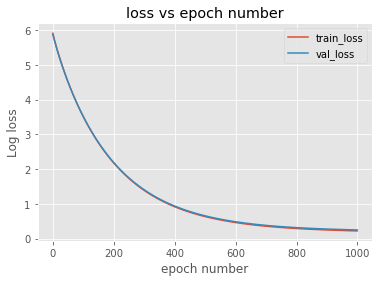

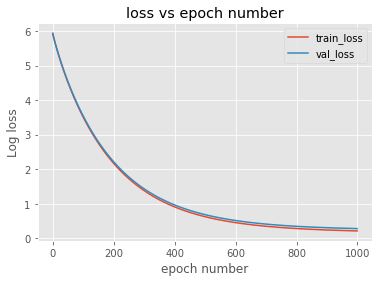

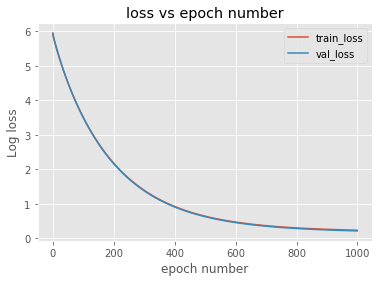

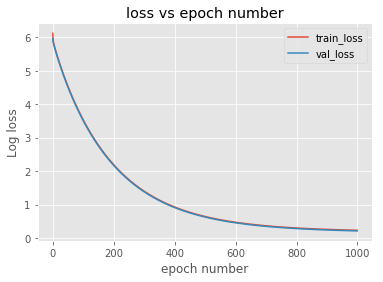

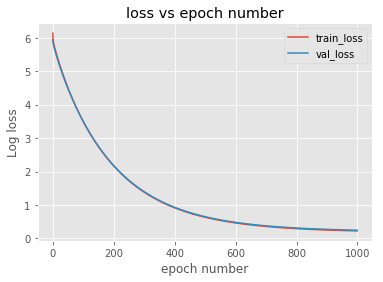

In [13]:
# Plot learning curves for validation and training data during learning
for history in train_results['history']:
    show_loss(history)

# EVALUATION ON TEST DATASET

In [15]:
# Overall Accuracy, Precision, Recall and F1 score for test dataset for each model from cross validation

test_results = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1_score': []}
confusion_matrixes = []
for model in train_results['models']:
    predicted = model.predict(x_test)
    
    predicted = np.asarray([np.round(j[0]) for j in predicted])
    actual = np.asarray([j[0] for j in y_test])
        
    TP = np.count_nonzero(predicted * actual)
    TN = np.count_nonzero((predicted - 1) * (actual - 1))
    FP = np.count_nonzero(predicted * (actual - 1))
    FN = np.count_nonzero((predicted - 1) * actual)

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns =['actual 1', 'actual 0'], index=['predicted 1', 'predicted 0'])
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = metrics.accuracy_score(actual, predicted)
    
    test_results['Accuracy'].append(accuracy)
    test_results['Precision'].append(precision)
    test_results['Recall'].append(recall)
    test_results['F1_score'].append(f1)
    confusion_matrixes.append(confusion_matrix)
    
columns = ['Accuracy', 'Precision', 'Recall', 'F1_score']
indexes = ['K-fold {}'.format(i) for i in range(1, N_SPLITS+1)]
results_dataframe = pd.DataFrame(data=test_results, columns=columns, index=indexes)
results_dataframe

,Accuracy,Precision,Recall,F1_score
K-fold 1,0.981654,0.080817,0.90099,0.148329
K-fold 2,0.983041,0.086915,0.90099,0.158537
K-fold 3,0.982673,0.085206,0.90099,0.155689
K-fold 4,0.983761,0.090457,0.90099,0.164408
K-fold 5,0.987430,0.114178,0.90099,0.202673


/home/maciejpesko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


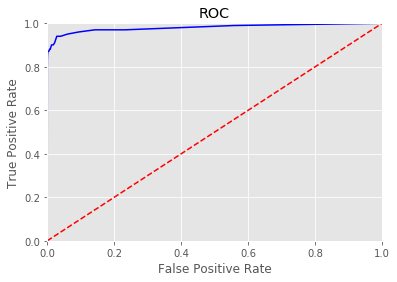

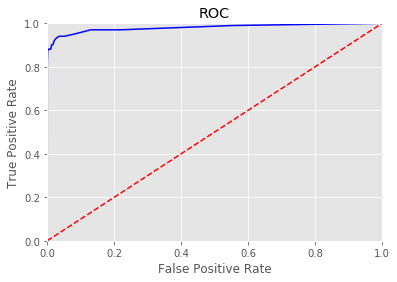

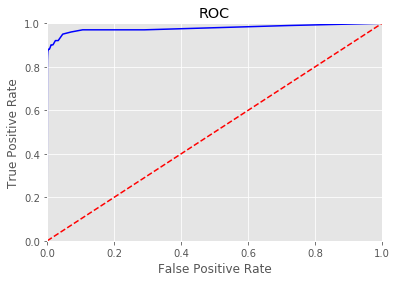

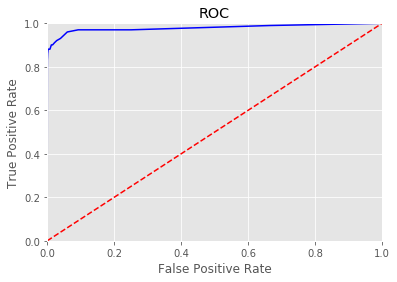

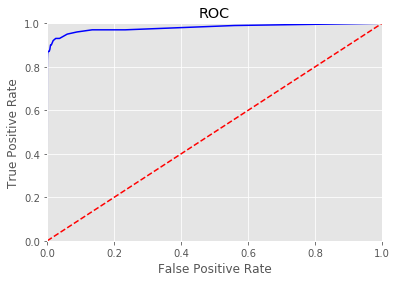

In [16]:
for model in train_results['models']:
    TPR_array = []
    FPR_array = []
    for i in range(-50,50,5):
        predicted = model.predict(x_test)
        predicted = np.asarray([np.round(j[0]+i/100) for j in predicted])
        actual = np.asarray([j[0] for j in y_test])

        TP = np.count_nonzero(np.multiply(predicted, actual))
        TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
        FP = np.count_nonzero(np.multiply(predicted, actual - 1))
        FN = np.count_nonzero(np.multiply(predicted - 1, actual))

        TPR_array.append(TP / (TP+FN))
        FPR_array.append(FP / (FP+TN))

    plot_ROC(TPR_array, FPR_array)

In [17]:
# Confusion matrixes for each valdation
for matrix in confusion_matrixes:
    display(matrix)


,actual 1,actual 0
predicted 1,91,1035
predicted 0,10,55826


,actual 1,actual 0
predicted 1,91,956
predicted 0,10,55905


,actual 1,actual 0
predicted 1,91,977
predicted 0,10,55884


,actual 1,actual 0
predicted 1,91,915
predicted 0,10,55946


,actual 1,actual 0
predicted 1,91,706
predicted 0,10,56155
